In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from causallib.estimation import IPW
from sklearn.linear_model import LogisticRegression
from causallib.evaluation import evaluate

In [2]:
# 加载数据
japan_data = pd.read_csv(r'E:\05-Study in Adelaide\PHD-research\02-Ai\Using-ML-to-Predict-Life-Satisfaction\Japan_scaling.csv')
uk_data = pd.read_csv(r"E:\05-Study in Adelaide\PHD-research\02-Ai\Using-ML-to-Predict-Life-Satisfaction\UK_scaling.csv")

# 查看数据结构
print(japan_data.head())
print(japan_data.info())
print(uk_data.head())
print(uk_data.info())


   ST004D01T  ZST016Q01NA_1  ZST185Q01HA_1    ZAGE_1   ZESCS_1  ZICTRES_1  \
0          2      -0.847933       0.444148 -1.561107  1.803623   1.741331   
1          2       0.314032       0.444148  0.171333  0.080161  -0.744134   
2          1       1.088676       0.444148  1.037553 -0.162452  -0.316612   
3          1      -0.847933       1.606777  0.171333  0.777743  -0.005642   
4          1      -2.009897      -0.718481  0.483172 -0.328046  -1.497813   

   ZDISCLIMA_1  ZTEACHSUP_1  ZDIRINS_1  ZPERFEED_1  ...  ZATTLNACT_1  \
0     1.291189     1.292605  -0.233752    0.837577  ...    -0.875158   
1     1.291189     1.292605   0.929566    2.389885  ...     0.950288   
2     1.291189     1.292605   1.637454   -0.857951  ...     0.950288   
3     1.291189     0.720054   0.205251   -0.527761  ...     0.950288   
4     0.281176    -0.484774  -1.251298   -0.527761  ...    -0.875158   

   ZCOMPETE_1  ZWORKMAST_1  ZGFOFAIL_1  ZEUDMO_1   ZSWBP_1  ZRESILIENCE_1  \
0    0.389969     0.223081 

In [3]:

def process_pisa_data(data):
    """
    处理PISA数据集 准备因果分析
    
    Parameters:
    data (pd.DataFrame): 原始PISA数据
    
    Returns:
    pd.DataFrame: 处理后的数据集和变量分组
    """
    # 1. 定义变量组
    outcome_var = 'ZST016Q01NA_1'  # 生活满意度（结果变量）
    
    # 定义不同类型的自变量
    demographic_vars = ['ZAGE_1', 'ST004D01T', 'ZESCS_1']  # 人口统计变量
    
    school_vars = [
        'ZICTRES_1', 'ZDISCLIMA_1', 'ZTEACHSUP_1', 'ZDIRINS_1',
        'ZPERFEED_1', 'ZSTIMREAD_1', 'ZADAPTIVITY_1', 'ZTEACHINT_1'
    ]  # 学校和教学相关变量
    
    psychological_vars = [
        'ZJOYREAD_1', 'ZATTLNACT_1', 'ZWORKMAST_1', 'ZGFOFAIL_1',
        'ZEUDMO_1', 'ZSWBP_1', 'ZRESILIENCE_1', 'ZMASTGOAL_1'
    ]  # 心理和学习态度变量
    
    social_vars = [
        'ZBELONG_1', 'ZBEINGBULLIED_1', 'ZPERCOMP_1', 
        'ZPERCOOP_1', 'ZCOMPETE_1', 'ZEMOSUPS_1'
    ]  # 社交和情感支持变量
    
    # 2. 创建处理后的数据框
    features = demographic_vars + school_vars + psychological_vars + social_vars
    processed_df = data[features + [outcome_var]].copy()
    
    # 3. 处理缺失值
    processed_df = processed_df.fillna(processed_df.mean())
    
    # 4. 创建变量分组字典
    variable_groups = {
        'demographic': demographic_vars,
        'school': school_vars,
        'psychological': psychological_vars,
        'social': social_vars,
        'all': features
    }
    
    return processed_df, variable_groups

def analyze_variable_relationships(df, variable_groups):
    """
    分析变量之间的关系，特别是与生活满意度的关系
    """
    results = {}
    
    # 计算与生活满意度的相关性
    correlations = df.corr()['ZST016Q01NA_1'].sort_values()
    results['outcome_correlations'] = correlations
    
    # 计算各组变量与生活满意度的平均相关性
    group_correlations = {}
    for group_name, variables in variable_groups.items():
        if group_name != 'all':
            group_corr = abs(correlations[variables]).mean()
            group_correlations[group_name] = group_corr
    
    results['group_correlations'] = pd.Series(group_correlations)
    
    # 计算完整的相关矩阵
    results['full_correlation_matrix'] = df.corr()
    
    return results

def visualize_correlations(results, title_prefix=""):
    """
    可视化相关性分析结果
    """
    # 创建一个3x1的图表布局
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))
    
    # 1. 与生活满意度的相关性条形图
    outcome_corr = results['outcome_correlations'].drop('ZST016Q01NA_1')
    sns.barplot(x=outcome_corr.values, y=outcome_corr.index, ax=ax1)
    ax1.set_title(f'{title_prefix}Variables Correlation with Life Satisfaction')
    ax1.set_xlabel('Correlation Coefficient')
    
    # 2. 变量组与生活满意度的平均相关性
    group_corr = results['group_correlations']
    sns.barplot(x=group_corr.values, y=group_corr.index, ax=ax2)
    ax2.set_title('Average Correlation by Variable Group')
    ax2.set_xlabel('Average Absolute Correlation')
    
    # 3. 相关性热图
    sns.heatmap(results['full_correlation_matrix'], 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                ax=ax3)
    ax3.set_title('Full Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

def identify_key_factors(results, threshold=0.1):
    """
    识别对生活满意度影响较大的关键因素
    """
    correlations = results['outcome_correlations'].drop('ZST016Q01NA_1')
    
    # 找出相关性超过阈值的变量
    significant_positive = correlations[correlations > threshold]
    significant_negative = correlations[correlations < -threshold]
    
    return {
        'positive_factors': significant_positive,
        'negative_factors': significant_negative
    }

In [4]:
def perform_causal_analysis(df, treatment_var, outcome_var='ZST016Q01NA_1', covariates=None):
    """
    Perform causal effect analysis for a single treatment variable
    
    Parameters:
    df: DataFrame containing the data
    treatment_var: Name of treatment variable
    outcome_var: Name of outcome variable (defaults to life satisfaction)
    covariates: List of covariate names (if None, uses all variables except treatment and outcome)
    
    Returns:
    dict: Dictionary containing causal effect estimates and evaluation results
    """
    # Prepare data
    if covariates is None:
        covariates = [col for col in df.columns if col not in [treatment_var, outcome_var]]
    
    # Prepare treatment variable (binary)
    a = (df[treatment_var] > df[treatment_var].median()).astype(int)
    
    # Prepare covariates and outcome
    X = df[covariates]
    y = df[outcome_var]
    
    # Initialize and train IPW model
    learner = LogisticRegression(max_iter=1000)
    ipw = IPW(
        learner=learner,
        clip_min=0.1,
        clip_max=0.9,
        use_stabilized=True
    )
    ipw.fit(X, a)
    
    # Calculate weights
    weights = ipw.compute_weights(X, a)
    
    # Estimate outcomes for treated and control groups
    treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
    control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))
    
    # Calculate ATE
    ate = treated_outcome - control_outcome
    
    # Calculate raw (unadjusted) effect for comparison
    raw_effect = float(y[a == 1].mean() - y[a == 0].mean())

    evaluation_results = evaluate(ipw, X, a, y)
    evaluation_results.plot_all()
    plt.tight_layout()
    
    return {
        'treatment': treatment_var,
        'ate': ate,
        'raw_effect': raw_effect,
        'treated_outcome': treated_outcome,
        'control_outcome': control_outcome,
        'weights': weights,
        'treatment_assignment': a,
        'treated_samples': int((a == 1).sum()),
        'control_samples': int((a == 0).sum())
    }

def analyze_multiple_treatments(df, treatments, outcome_var='ZST016Q01NA_1'):
    """
    Analyze causal effects for multiple treatment variables
    
    Parameters:
    df: DataFrame containing the data
    treatments: List of treatment variables to analyze
    outcome_var: Name of outcome variable
    
    Returns:
    dict: Dictionary containing results for each treatment variable
    """
    results = {}
    
    for treatment in treatments:
        print(f"\nAnalyzing treatment: {treatment}")
        covariates = [col for col in df.columns if col not in [treatment, outcome_var]]
        result = perform_causal_analysis(df, treatment, outcome_var, covariates)
        results[treatment] = result
        
        # Print summary statistics for each treatment
        print(f"Treatment group size: {result['treated_samples']}")
        print(f"Control group size: {result['control_samples']}")
        print(f"ATE: {result['ate']:.4f}")
        print(f"Raw effect: {result['raw_effect']:.4f}")
        print(f"Effect change: {((result['ate'] - result['raw_effect'])/result['raw_effect']*100):.1f}%")
    
    return results

def summarize_causal_effects(results):
    """
    Summarize causal analysis results in a DataFrame
    
    Parameters:
    results: Dictionary of results from analyze_multiple_treatments
    
    Returns:
    pd.DataFrame: Summary of causal effects
    """
    summary = []
    
    for treatment, result in results.items():
        summary.append({
            'Treatment': treatment,
            'ATE': result['ate'],
            'Raw_Effect': result['raw_effect'],
            'Effect_Change_%': ((result['ate'] - result['raw_effect'])/result['raw_effect']*100),
            'Treated_Outcome': result['treated_outcome'],
            'Control_Outcome': result['control_outcome'],
            'Treatment_Group_Size': result['treated_samples'],
            'Control_Group_Size': result['control_samples']
        })
    
    return pd.DataFrame(summary).sort_values('ATE', ascending=False)

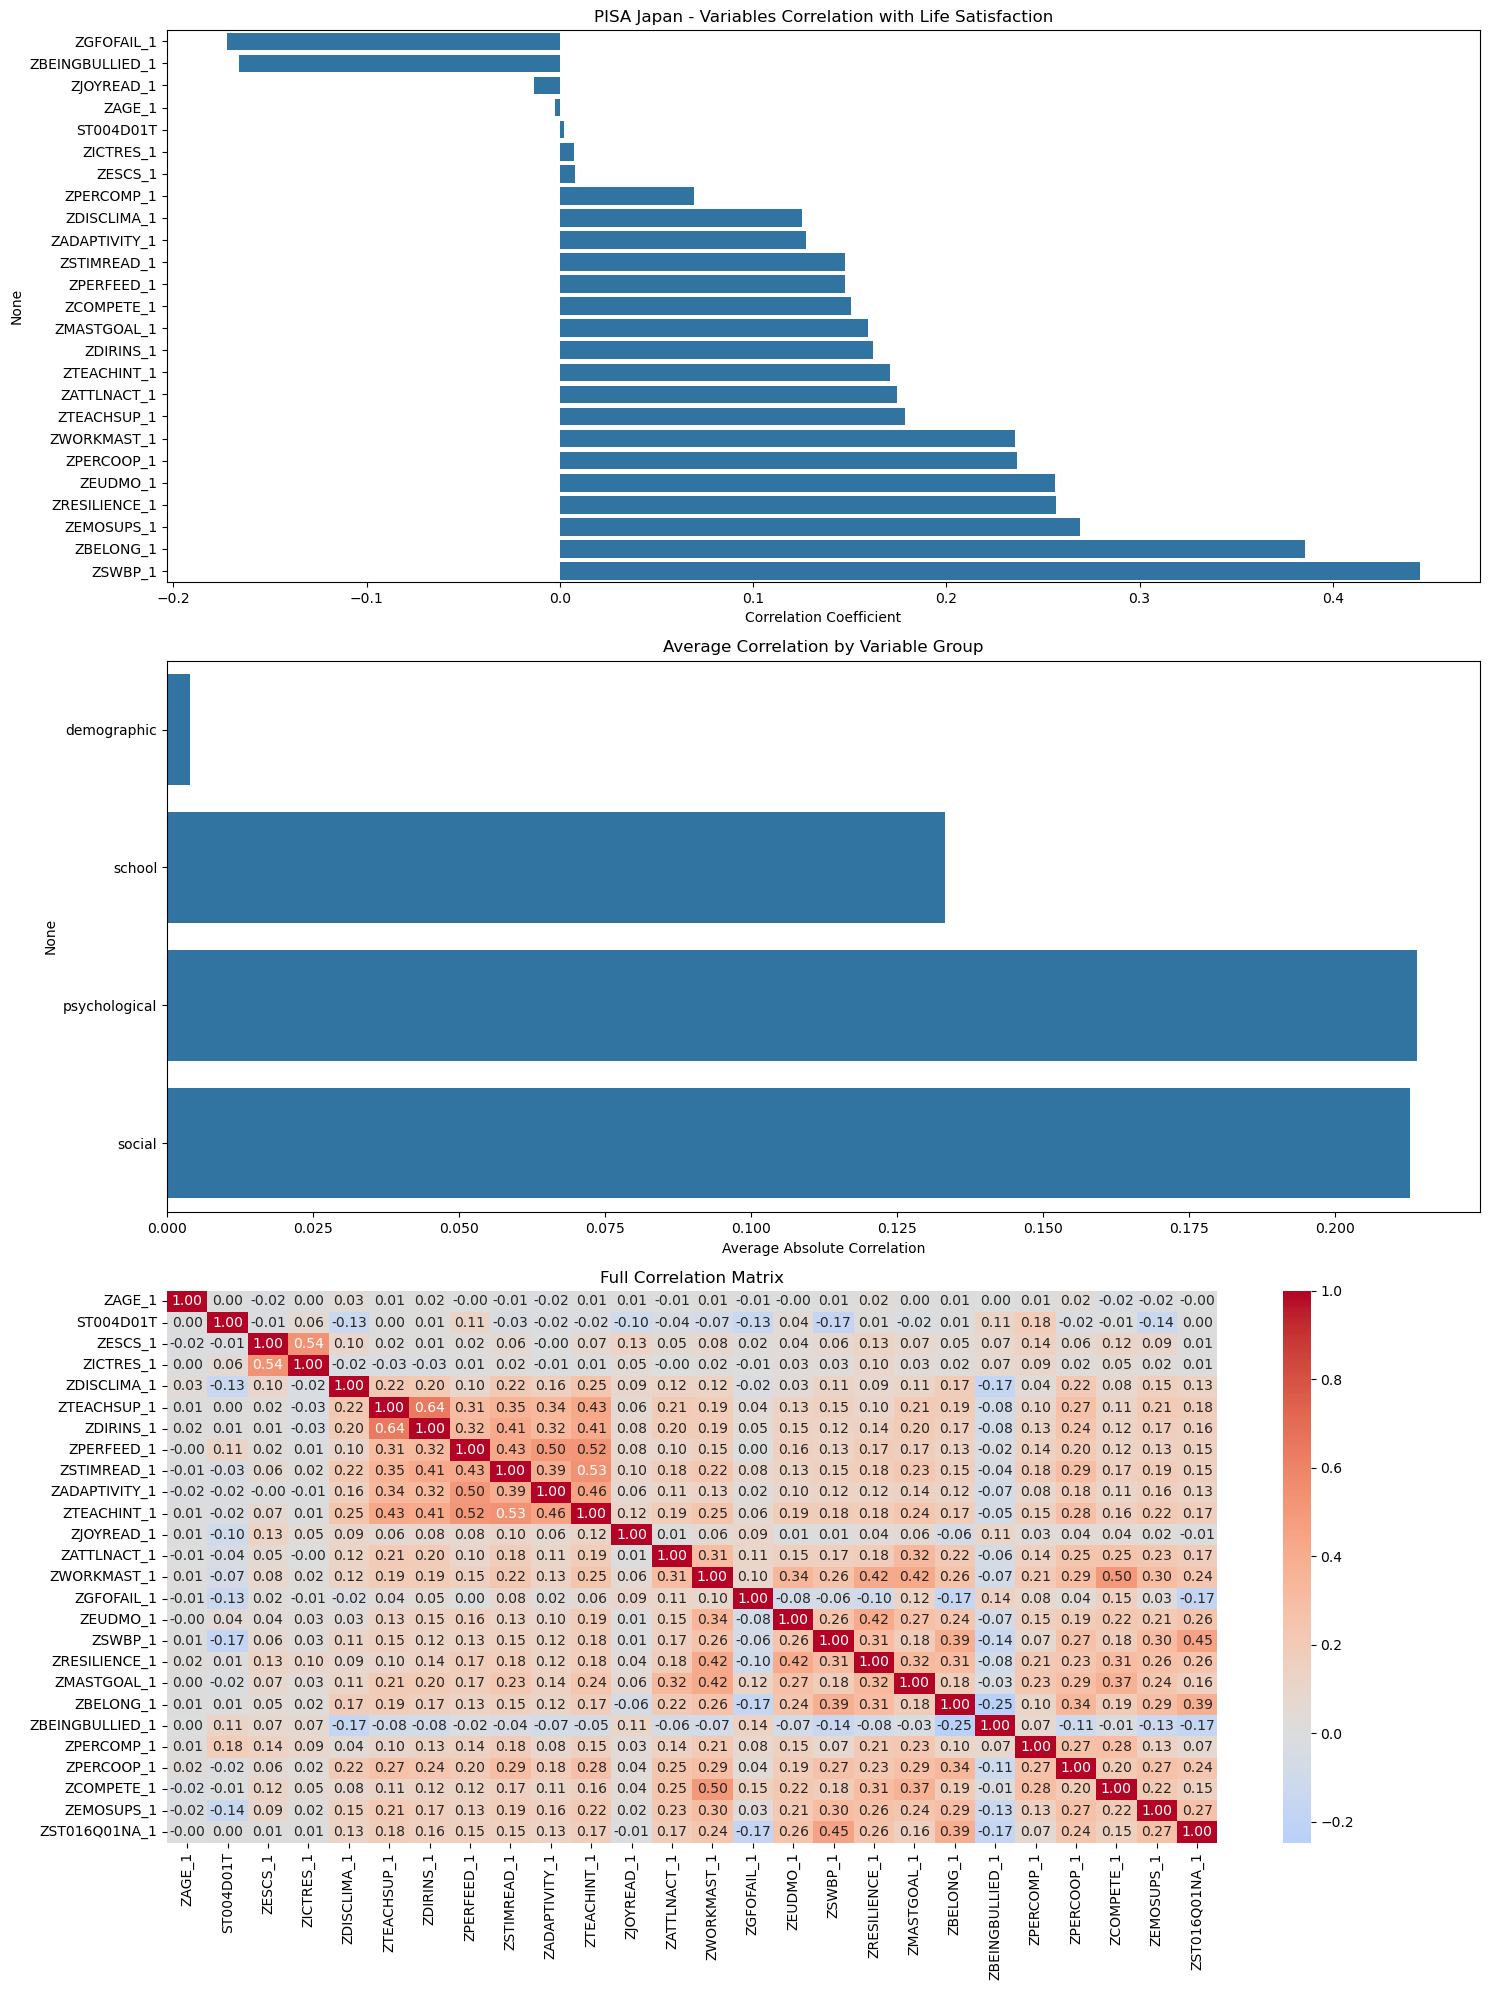


正向影响因素 (相关系数 > 0.1):
ZDISCLIMA_1      0.125448
ZADAPTIVITY_1    0.127453
ZSTIMREAD_1      0.147406
ZPERFEED_1       0.147810
ZCOMPETE_1       0.150559
ZMASTGOAL_1      0.159580
ZDIRINS_1        0.162114
ZTEACHINT_1      0.170783
ZATTLNACT_1      0.174306
ZTEACHSUP_1      0.178369
ZWORKMAST_1      0.235515
ZPERCOOP_1       0.236427
ZEUDMO_1         0.256358
ZRESILIENCE_1    0.256877
ZEMOSUPS_1       0.268944
ZBELONG_1        0.385703
ZSWBP_1          0.445242
Name: ZST016Q01NA_1, dtype: float64

负向影响因素 (相关系数 < -0.1):
ZGFOFAIL_1        -0.172343
ZBEINGBULLIED_1   -0.166162
Name: ZST016Q01NA_1, dtype: float64

各变量组与生活满意度的平均相关性强度:
demographic      0.004020
school           0.133340
psychological    0.214198
social           0.212837
dtype: float64


In [5]:
# 1. 处理数据
processed_df, variable_groups = process_pisa_data(japan_data)

# 2. 分析变量关系
relationship_results = analyze_variable_relationships(processed_df, variable_groups)

# 3. 可视化结果
visualize_correlations(relationship_results, "PISA Japan - ")

# 4. 识别关键因素
key_factors = identify_key_factors(relationship_results)

# 5. 打印结果
print("\n正向影响因素 (相关系数 > 0.1):")
print(key_factors['positive_factors'])

print("\n负向影响因素 (相关系数 < -0.1):")
print(key_factors['negative_factors'])

# 6. 打印变量组的平均相关性
print("\n各变量组与生活满意度的平均相关性强度:")
print(relationship_results['group_correlations'])


Analyzing treatment: ZSWBP_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 3048
Control group size: 3061
ATE: 0.4487
Raw effect: 0.7324
Effect change: -38.7%

Analyzing treatment: ZBELONG_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 3036
Control group size: 3073
ATE: 0.3045
Raw effect: 0.6781
Effect change: -55.1%

Analyzing treatment: ZEMOSUPS_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 2671
Control group size: 3438
ATE: 0.0665
Raw effect: 0.4128
Effect change: -83.9%

Analyzing treatment: ZRESILIENCE_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 3006
Control group size: 3103
ATE: 0.0533
Raw effect: 0.4350
Effect change: -87.8%

Analyzing treatment: ZEUDMO_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 3047
Control group size: 3062
ATE: 0.1102
Raw effect: 0.4034
Effect change: -72.7%

Analyzing treatment: ZBEINGBULLIED_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 1907
Control group size: 4202
ATE: -0.0887
Raw effect: -0.3275
Effect change: -72.9%

Causal Effect Estimates:
         Treatment       ATE  Raw_Effect  Effect_Change_%  Treated_Outcome  \
0          ZSWBP_1  0.448720    0.732383       -38.731491         0.241561   
1        ZBELONG_1  0.304462    0.678106       -55.101093         0.161403   
4         ZEUDMO_1  0.110186    0.403440       -72.688485         0.061878   
2       ZEMOSUPS_1  0.066509    0.412785       -83.887676         0.023148   
3    ZRESILIENCE_1  0.053269    0.435043       -87.755379         0.014180   
5  ZBEINGBULLIED_1 -0.088749   -0.327468       -72.898322        -0.067696   

   Control_Outcome  Treatment_Group_Size  Control_Group_Size  
0        -0.207159                  3048                3061  
1        -0.143059                  3036                3073  
4        -0.048308                  3047                3062  
2        -0.043361                  2671                3438  
3    

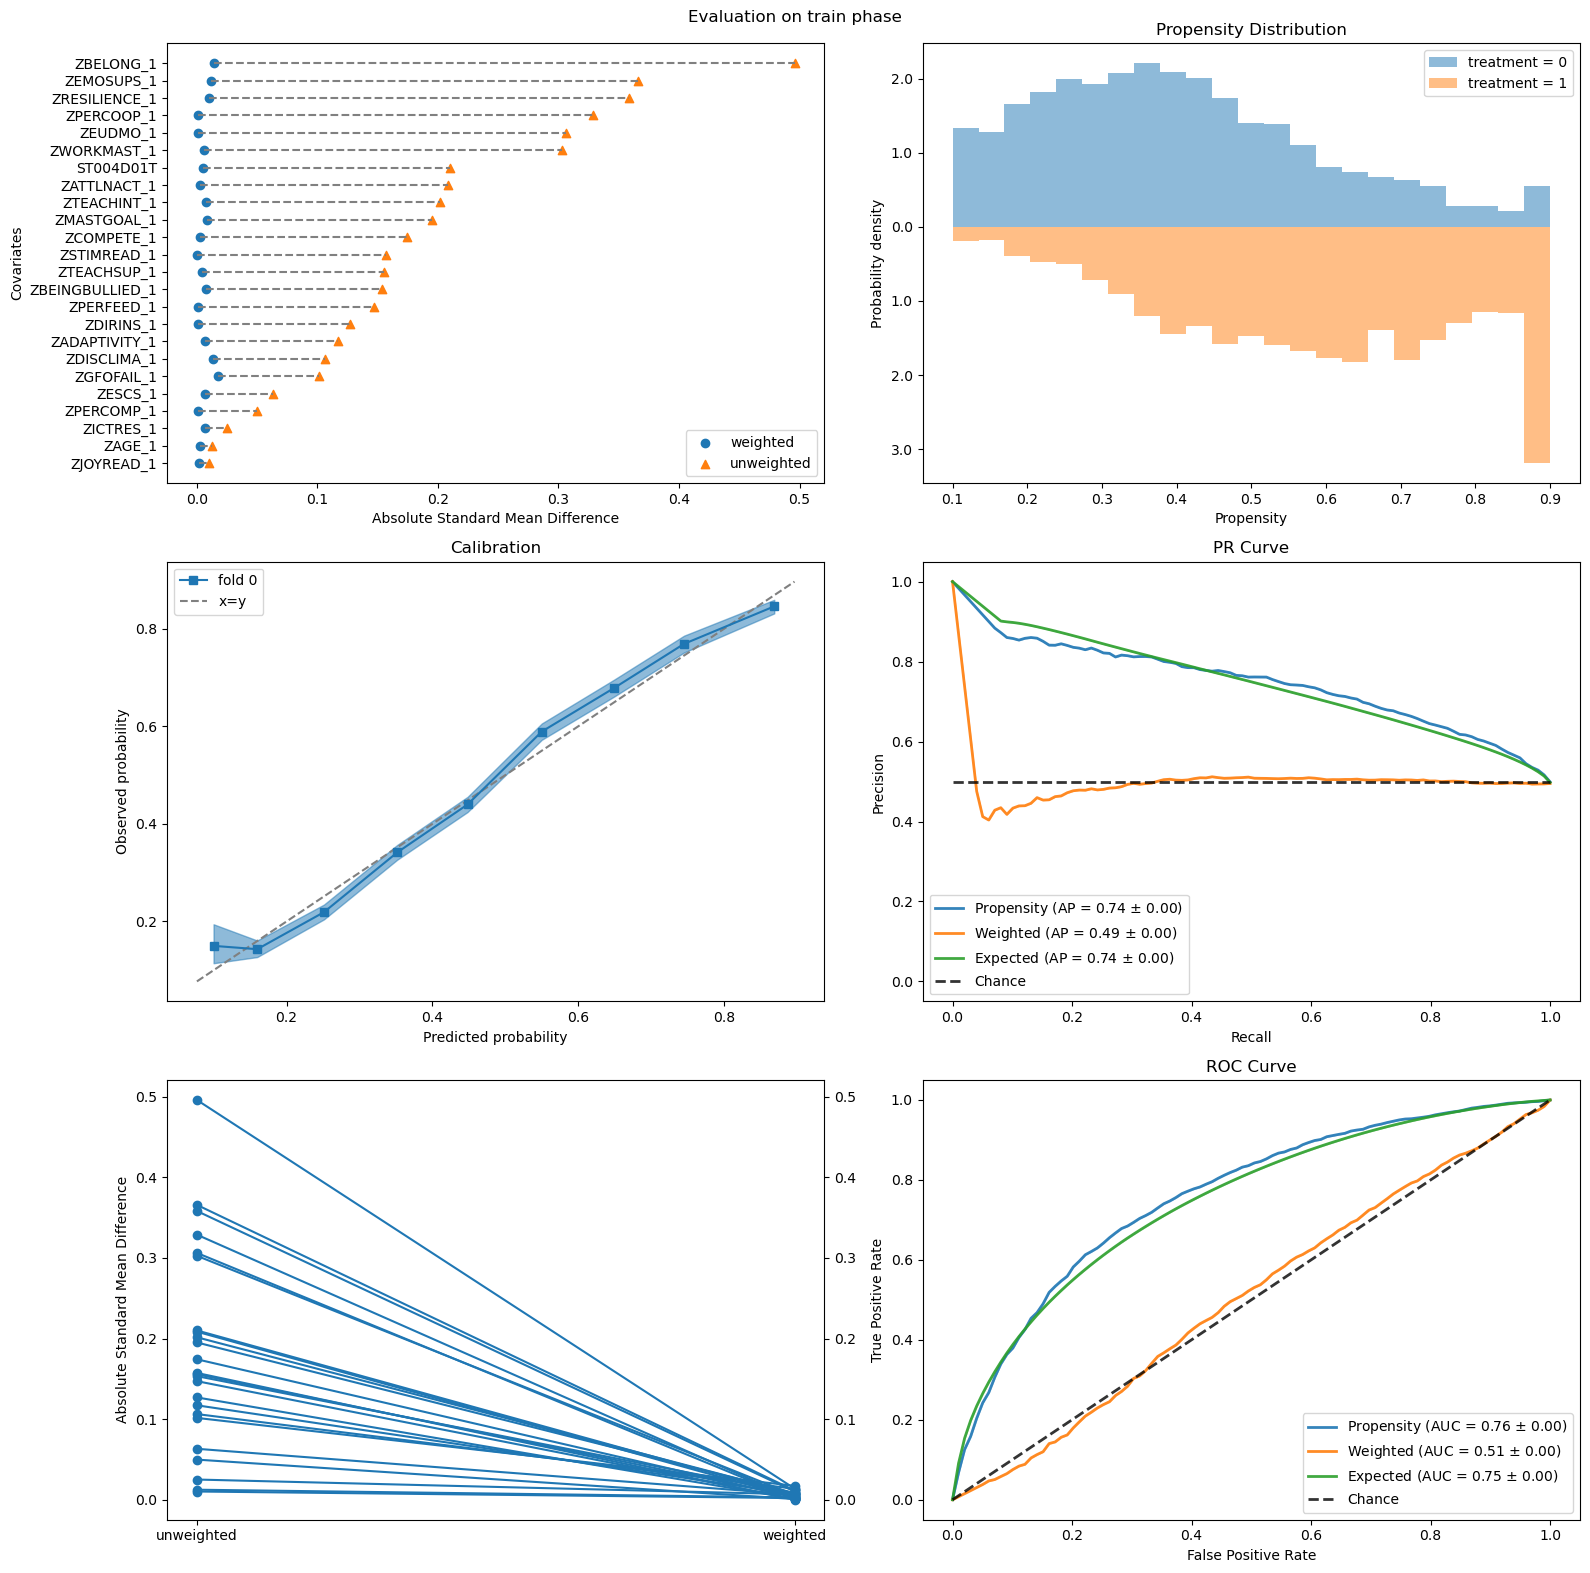

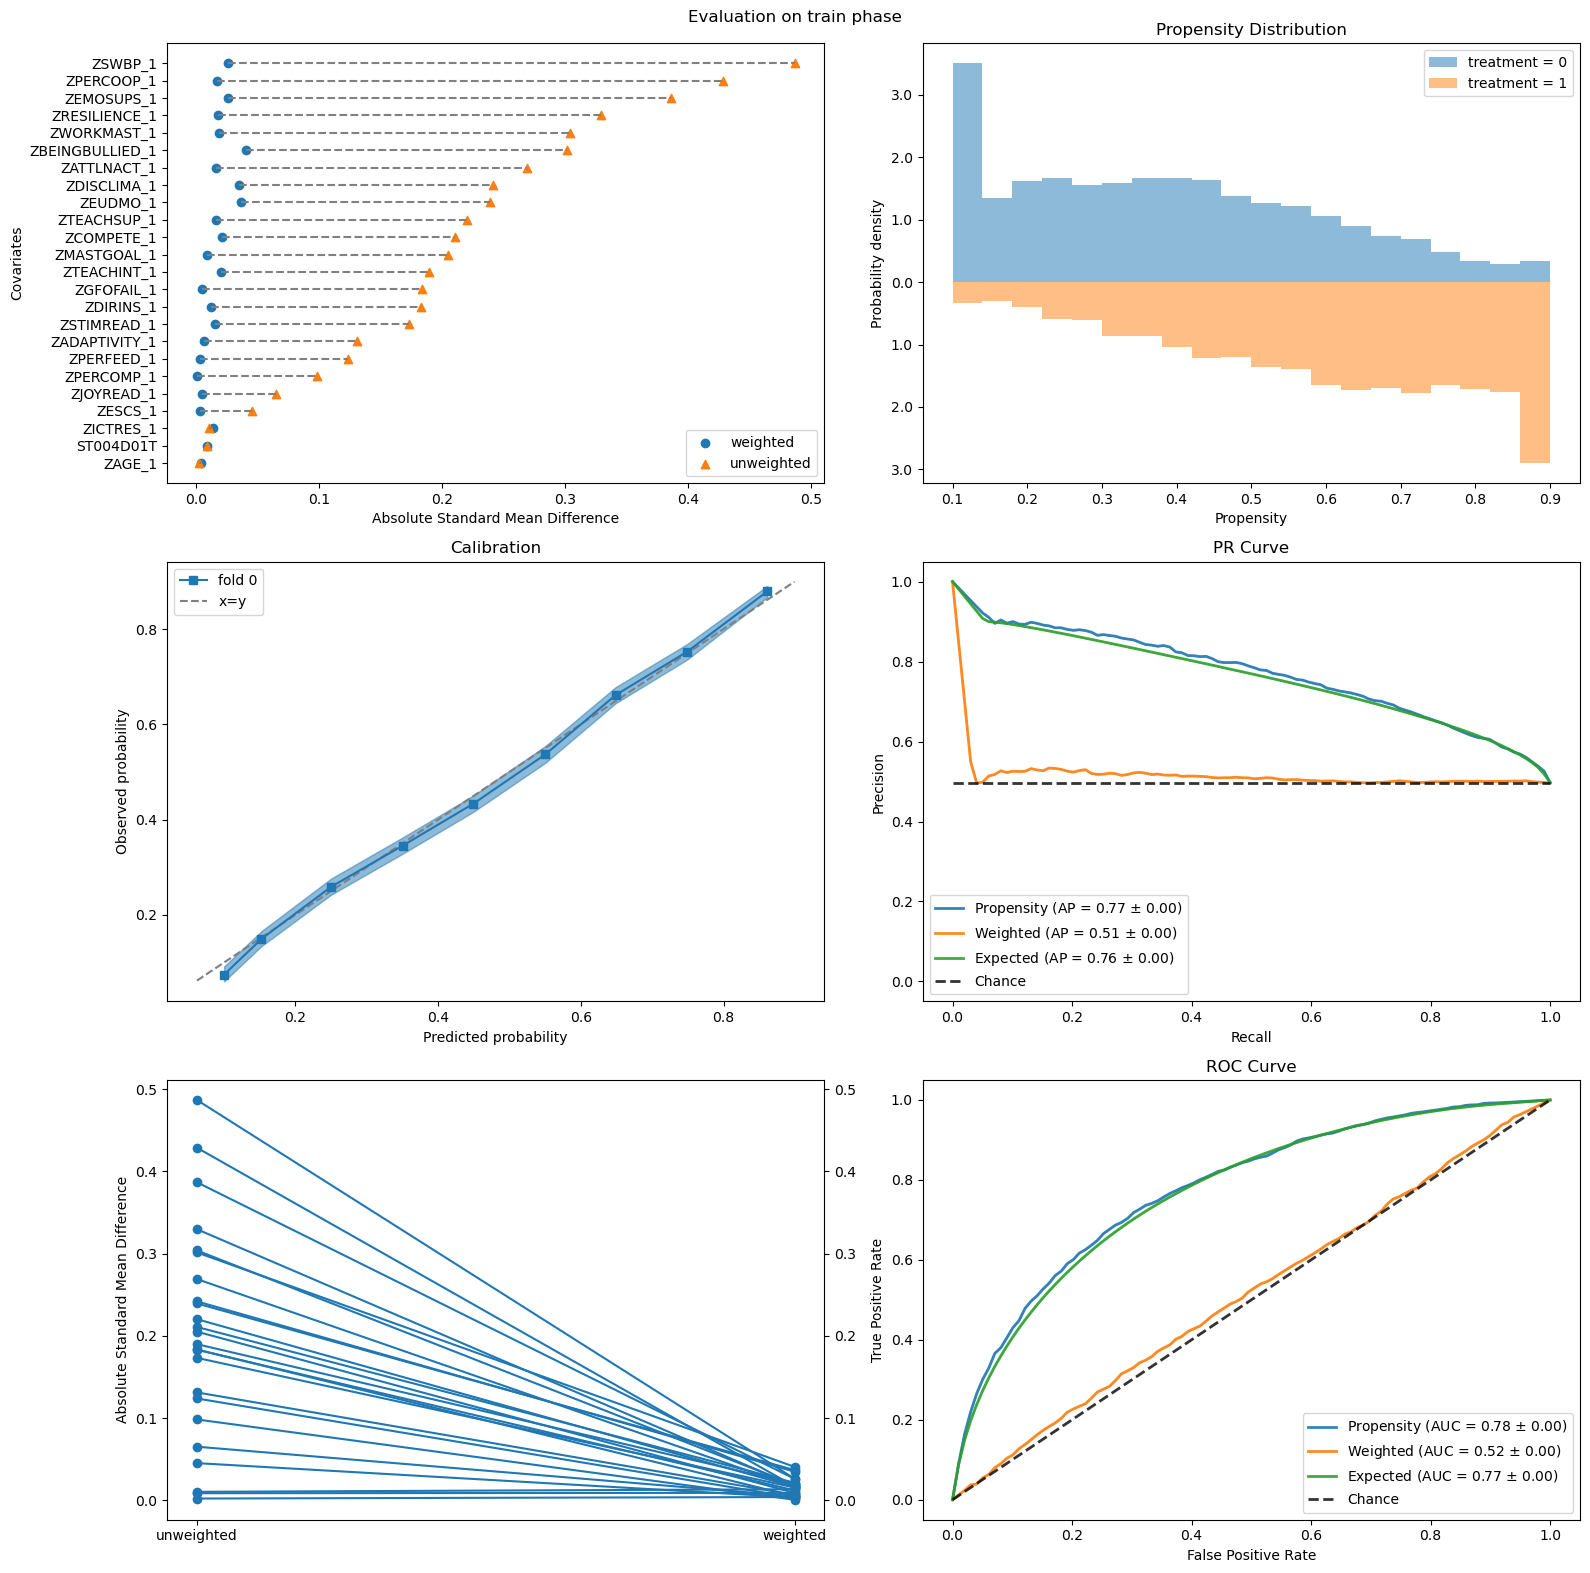

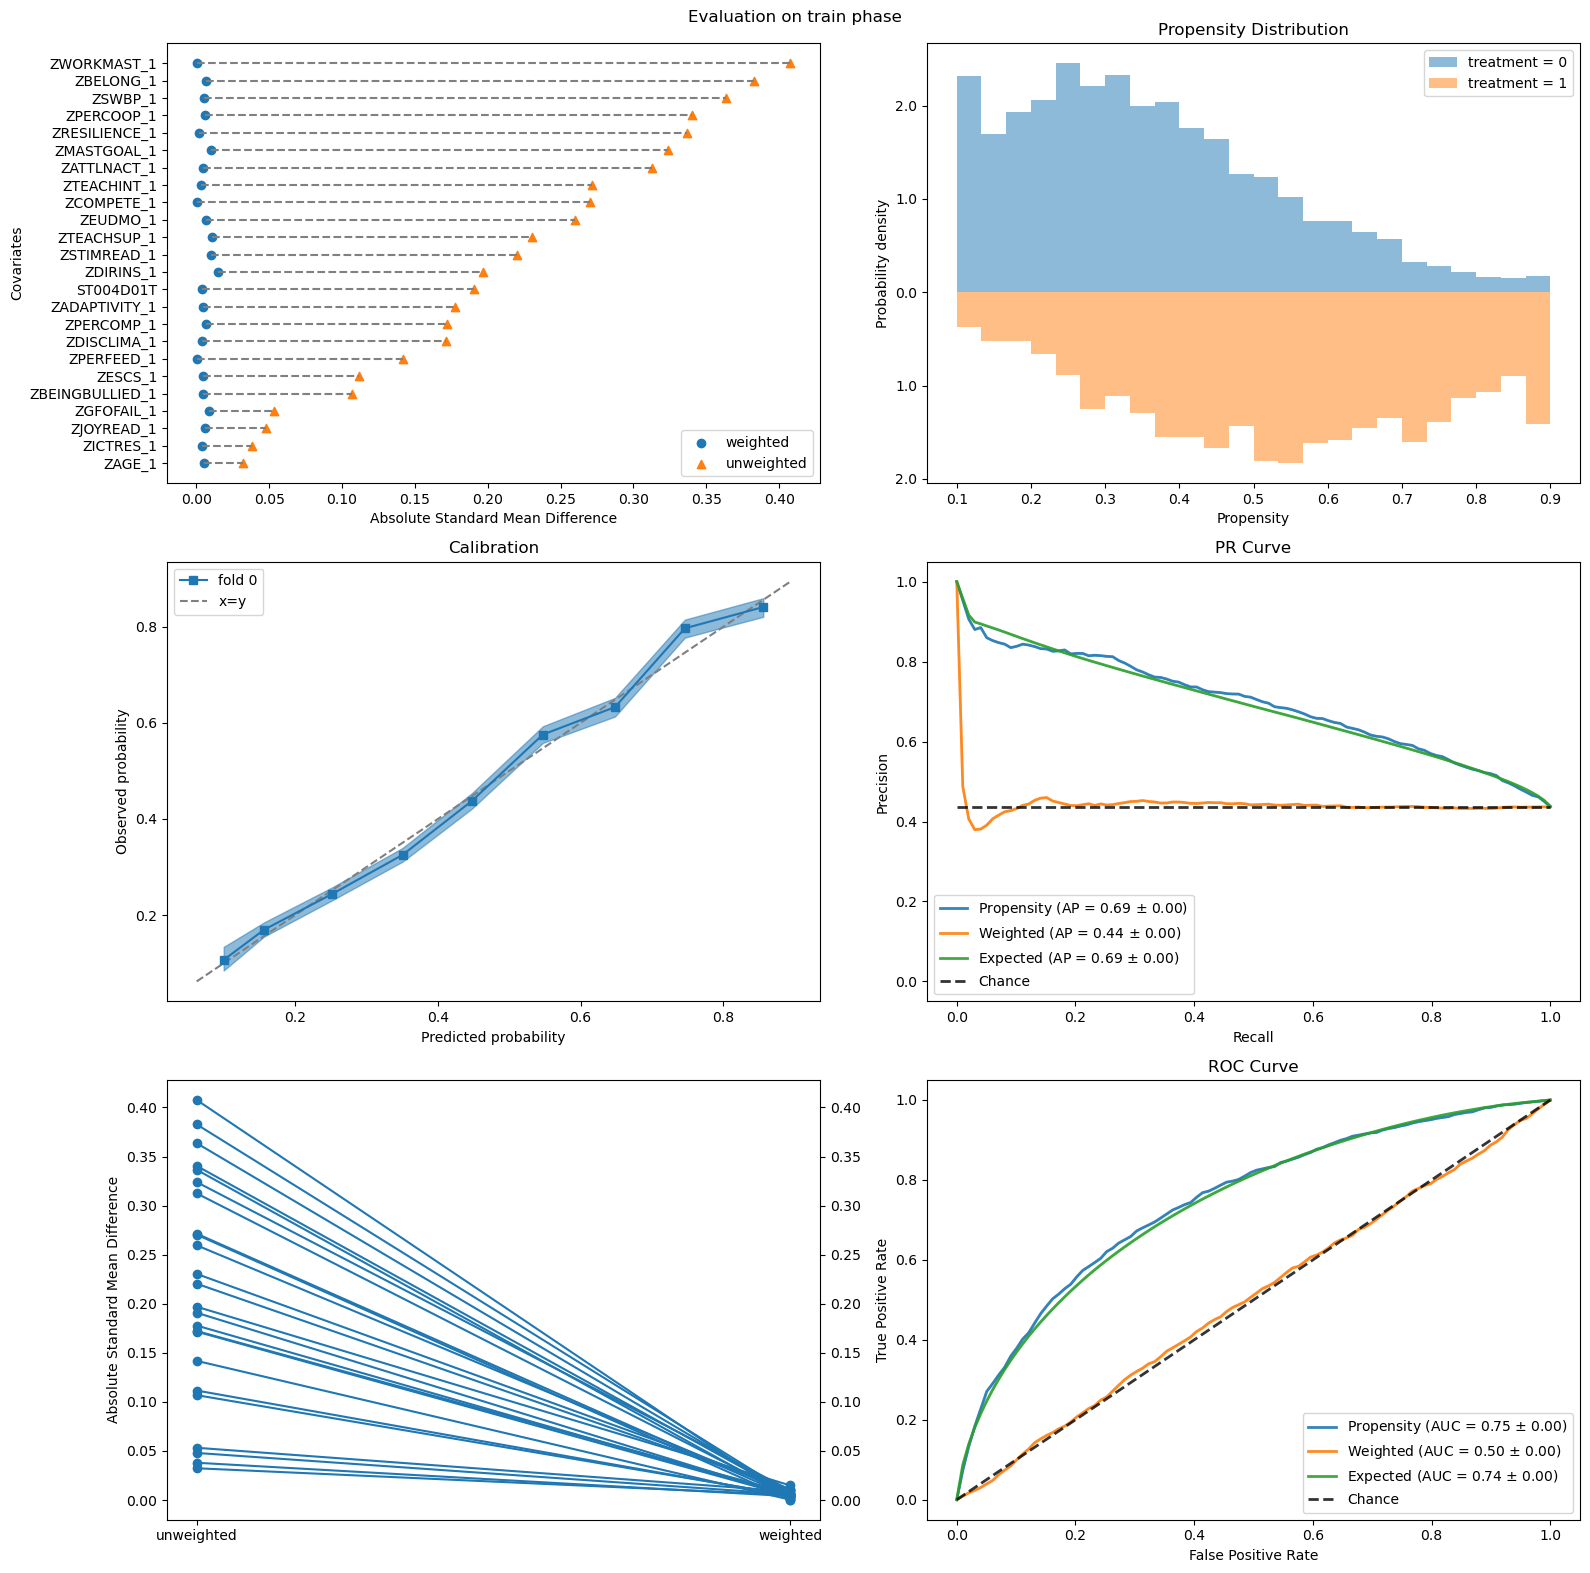

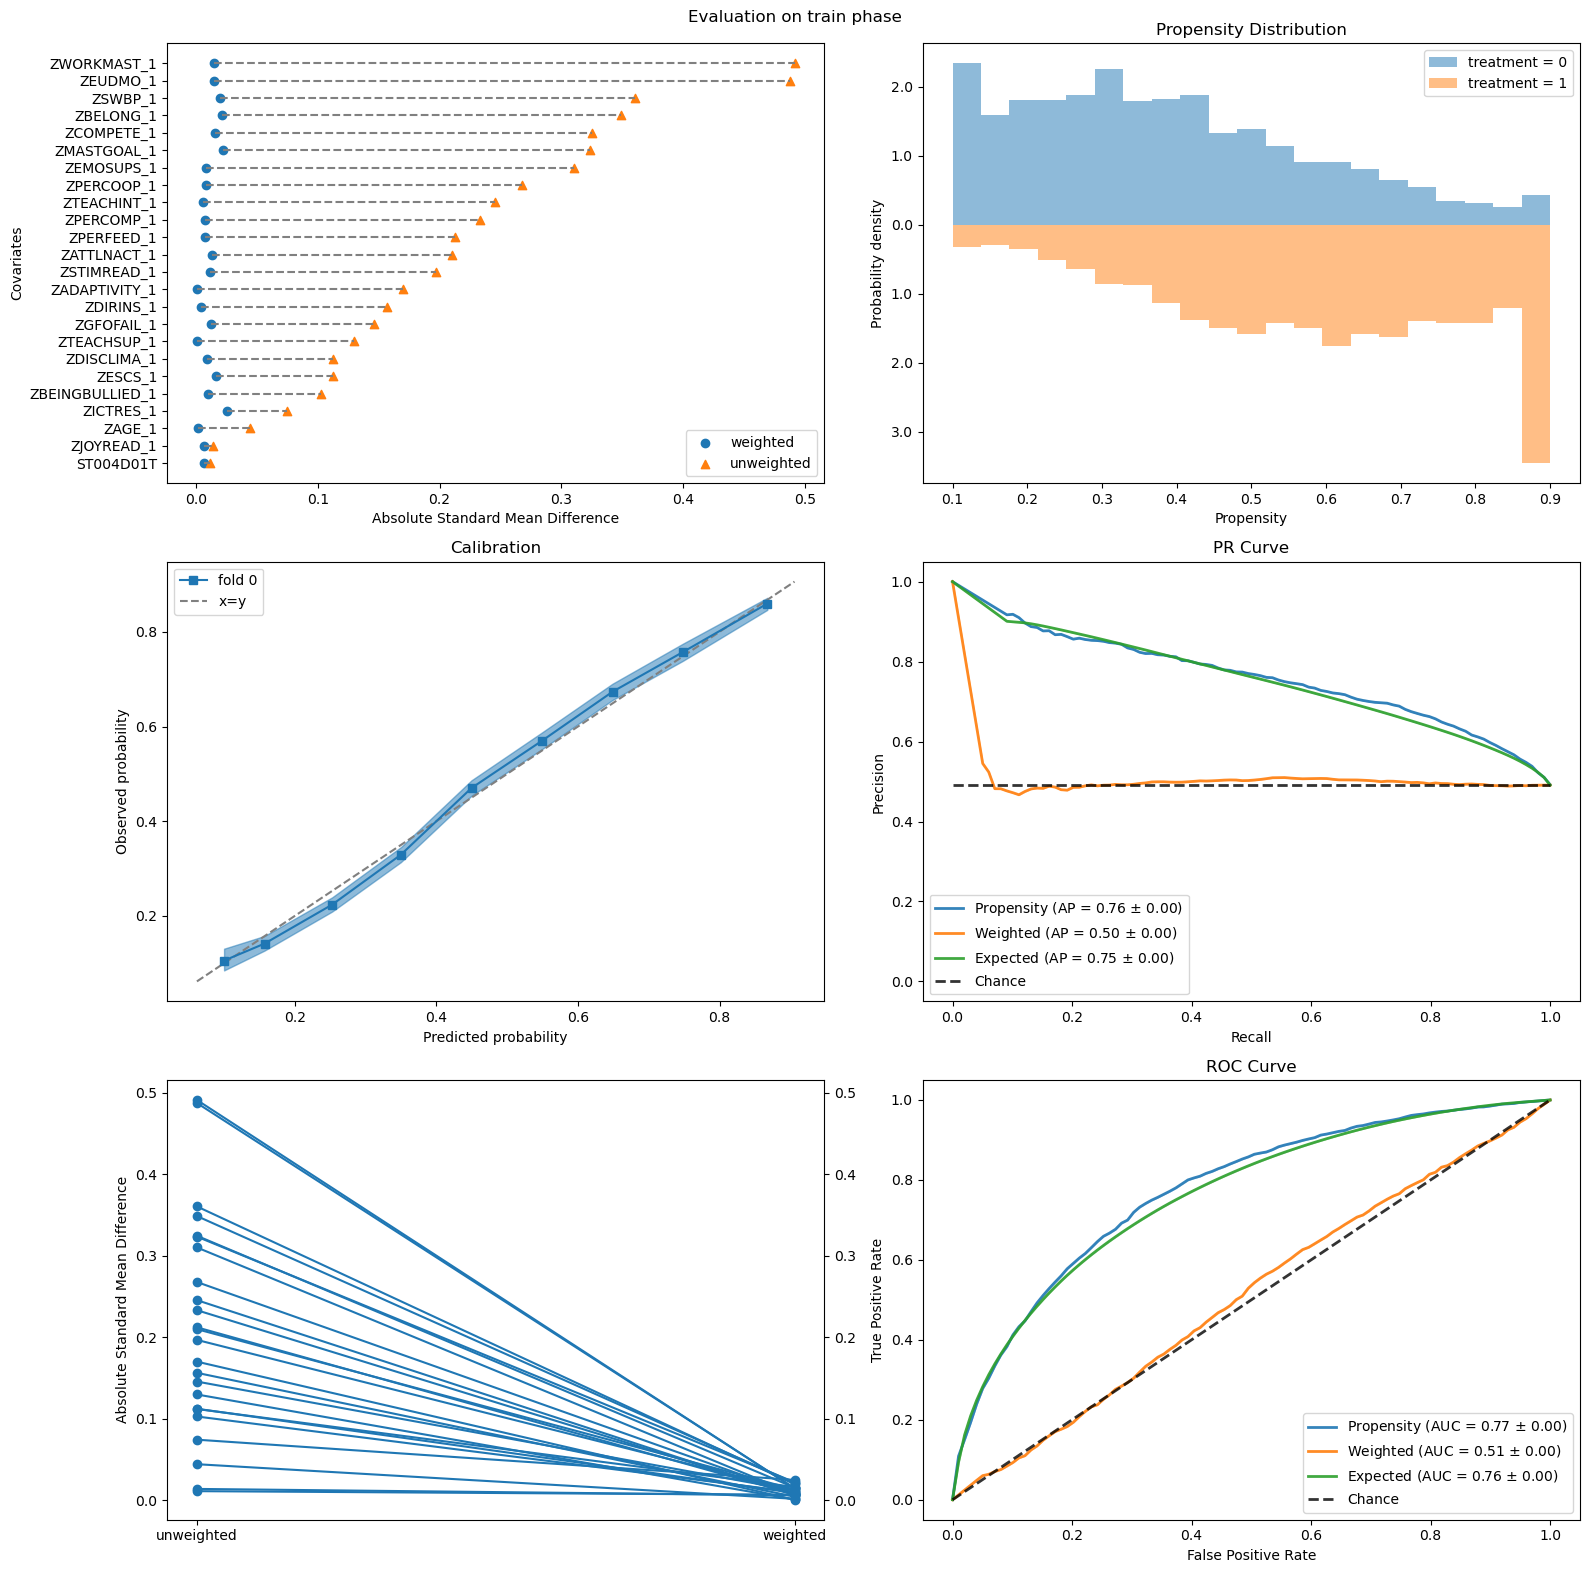

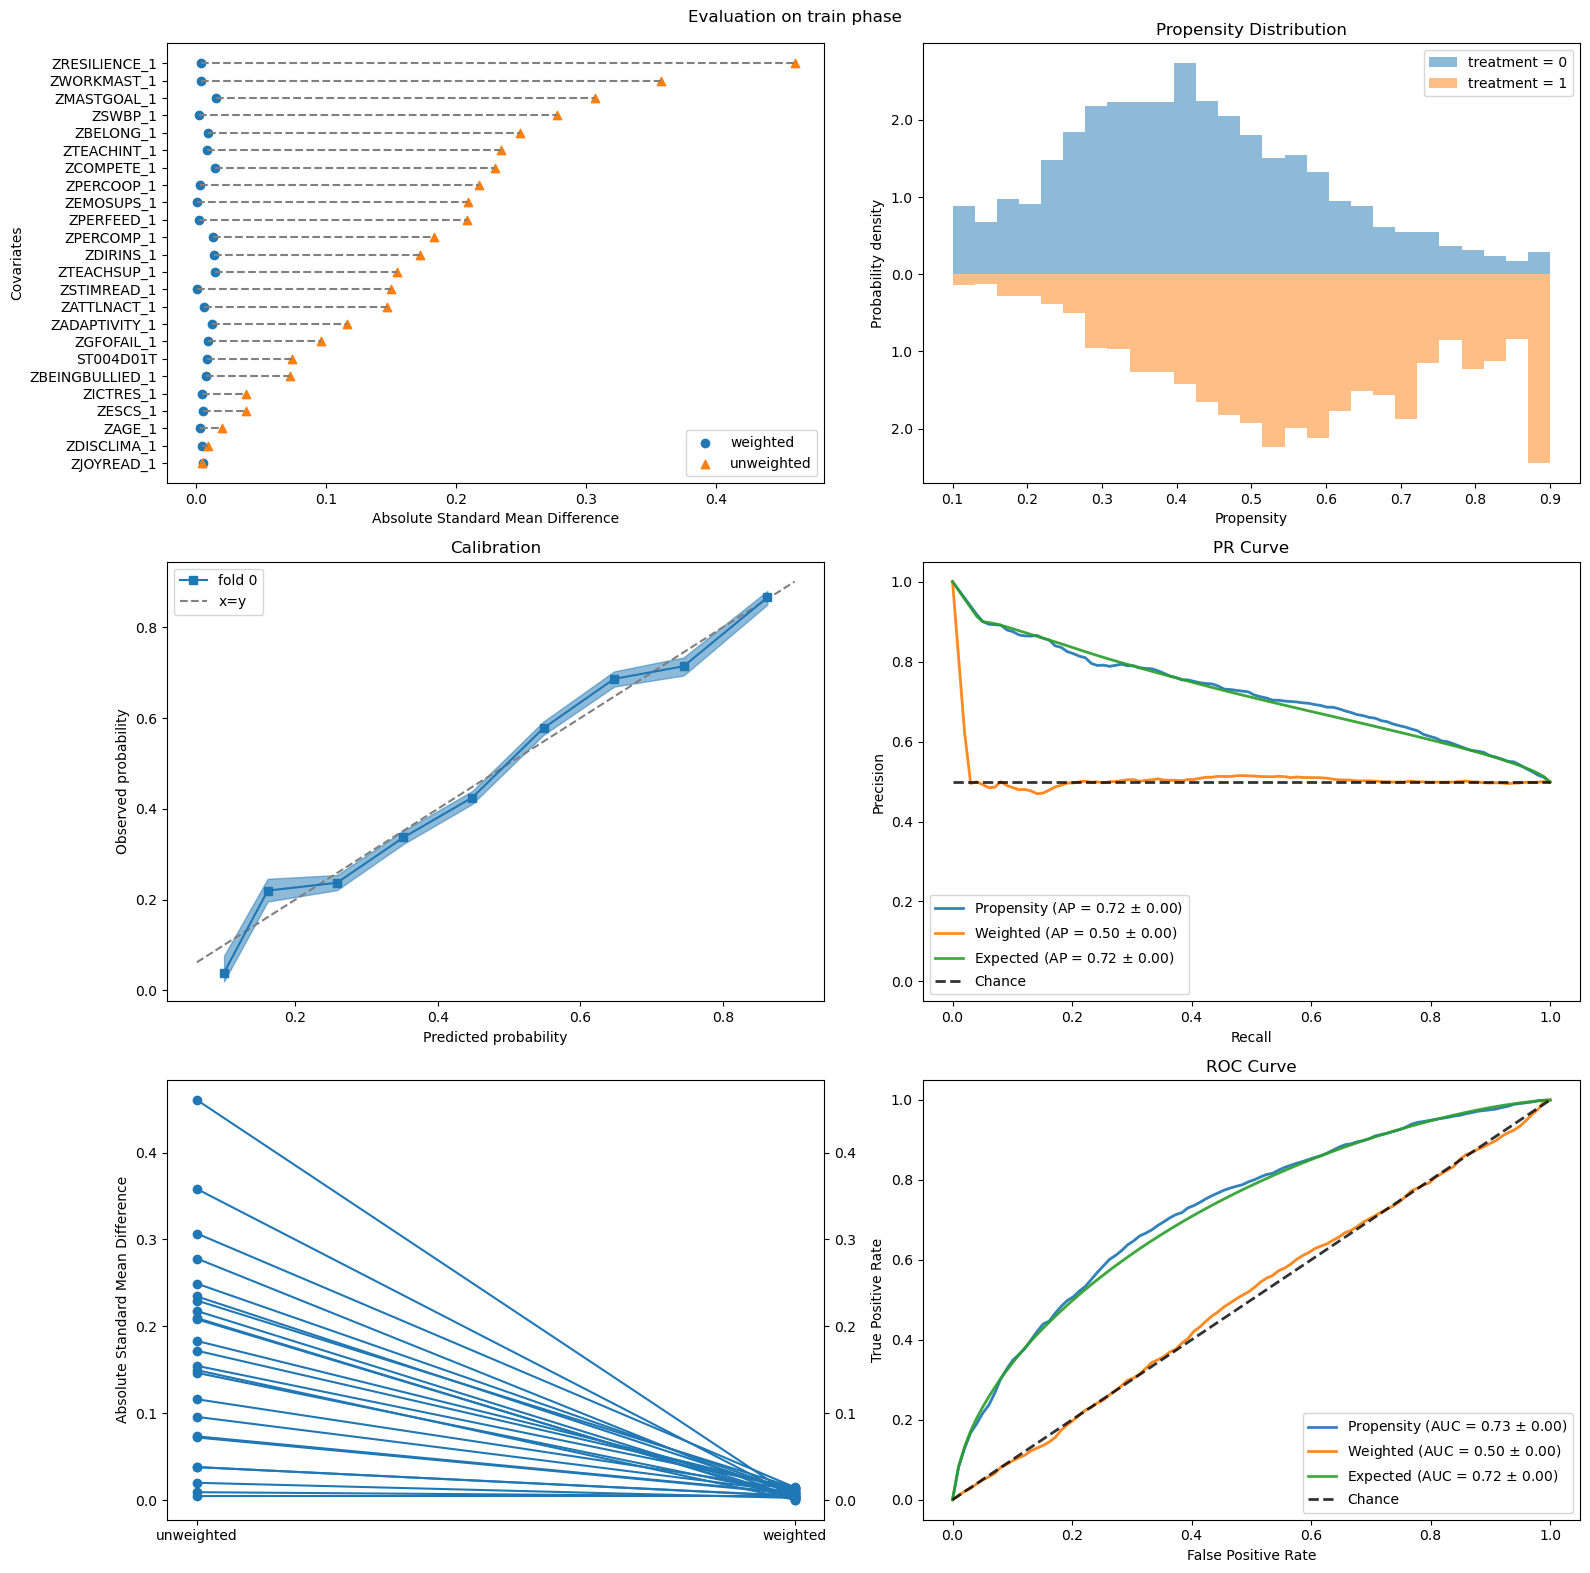

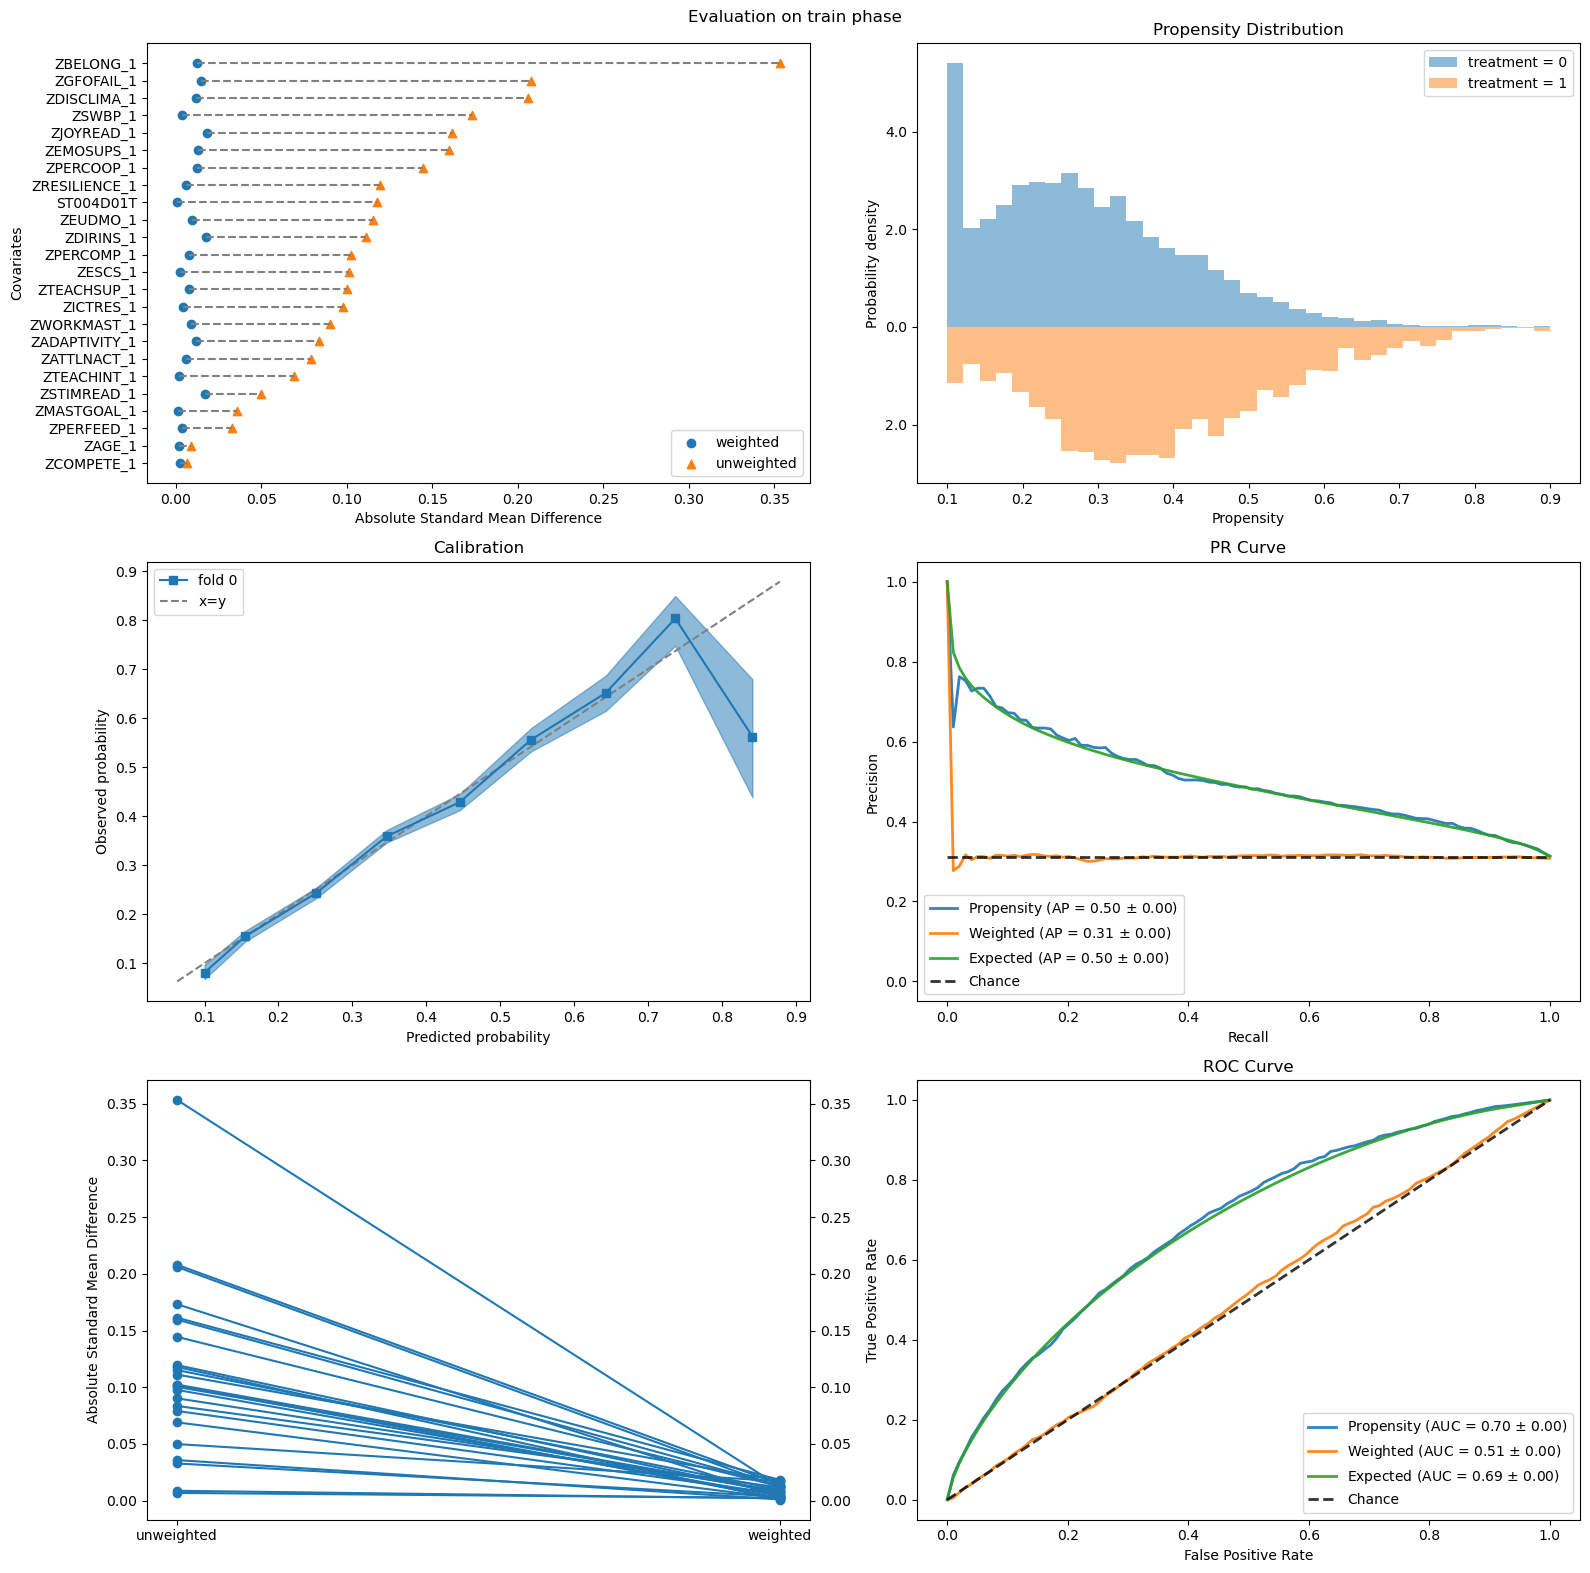

In [6]:
# Select key treatment variables for causal analysis
key_treatments = [
    'ZSWBP_1',       # Positive emotions
    'ZBELONG_1',     # Sense of belonging
    'ZEMOSUPS_1',    # Parental emotional support
    'ZRESILIENCE_1', # Psychological resilience
    'ZEUDMO_1',      # Sense of meaning in life
    'ZBEINGBULLIED_1'# Bullying experiences
]

# Perform causal analysis
causal_results = analyze_multiple_treatments(processed_df, key_treatments)

# Summarize results
summary = summarize_causal_effects(causal_results)
print("\nCausal Effect Estimates:")
print(summary)

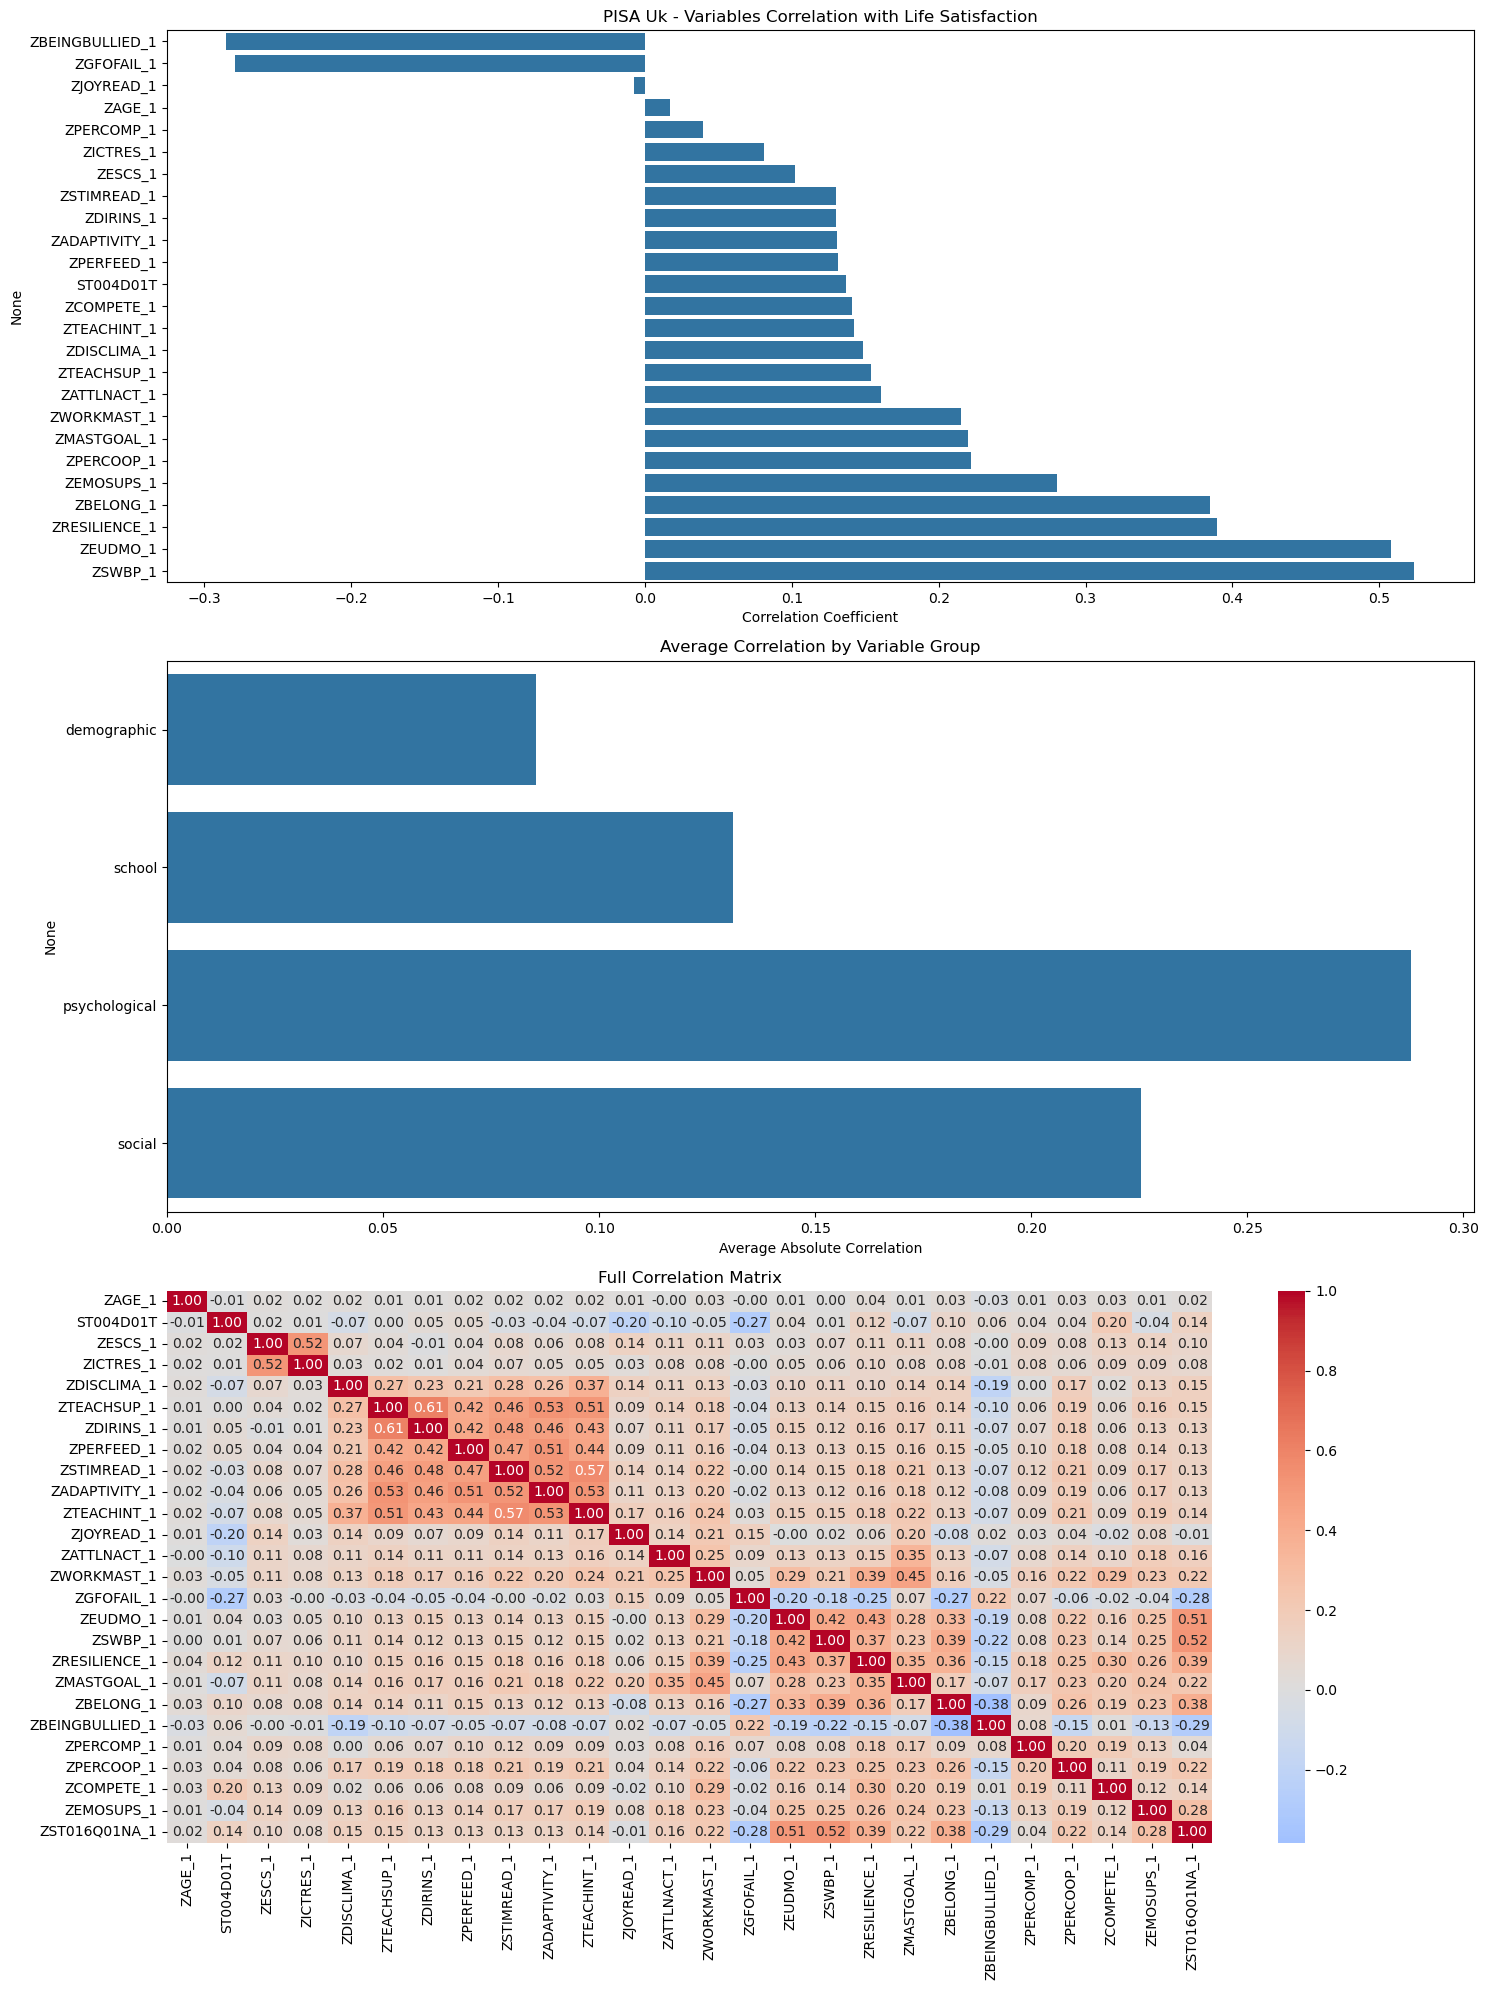


正向影响因素 (相关系数 > 0.1):
ZESCS_1          0.102172
ZSTIMREAD_1      0.129898
ZDIRINS_1        0.130172
ZADAPTIVITY_1    0.130513
ZPERFEED_1       0.131196
ST004D01T        0.137163
ZCOMPETE_1       0.141147
ZTEACHINT_1      0.142628
ZDISCLIMA_1      0.148774
ZTEACHSUP_1      0.154008
ZATTLNACT_1      0.160857
ZWORKMAST_1      0.215414
ZMASTGOAL_1      0.220236
ZPERCOOP_1       0.222021
ZEMOSUPS_1       0.280648
ZBELONG_1        0.384747
ZRESILIENCE_1    0.389255
ZEUDMO_1         0.507793
ZSWBP_1          0.523818
Name: ZST016Q01NA_1, dtype: float64

负向影响因素 (相关系数 < -0.1):
ZBEINGBULLIED_1   -0.285007
ZGFOFAIL_1        -0.279312
Name: ZST016Q01NA_1, dtype: float64

各变量组与生活满意度的平均相关性强度:
demographic      0.085498
school           0.130991
psychological    0.287983
social           0.225479
dtype: float64


In [7]:
# 1. 处理数据
processed_df_1, variable_groups_1 = process_pisa_data(uk_data)

# 2. 分析变量关系
relationship_results = analyze_variable_relationships(processed_df_1, variable_groups_1)

# 3. 可视化结果
visualize_correlations(relationship_results, "PISA Uk - ")

# 4. 识别关键因素
key_factors = identify_key_factors(relationship_results)

# 5. 打印结果
print("\n正向影响因素 (相关系数 > 0.1):")
print(key_factors['positive_factors'])

print("\n负向影响因素 (相关系数 < -0.1):")
print(key_factors['negative_factors'])

# 6. 打印变量组的平均相关性
print("\n各变量组与生活满意度的平均相关性强度:")
print(relationship_results['group_correlations'])


Analyzing treatment: ZSWBP_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 6399
Control group size: 7419
ATE: 0.4295
Raw effect: 0.8153
Effect change: -47.3%

Analyzing treatment: ZBELONG_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 6284
Control group size: 7534
ATE: 0.1160
Raw effect: 0.5904
Effect change: -80.4%

Analyzing treatment: ZEMOSUPS_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 6364
Control group size: 7454
ATE: 0.1118
Raw effect: 0.4698
Effect change: -76.2%

Analyzing treatment: ZRESILIENCE_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 6849
Control group size: 6969
ATE: 0.1832
Raw effect: 0.6794
Effect change: -73.0%

Analyzing treatment: ZEUDMO_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 6235
Control group size: 7583
ATE: 0.4140
Raw effect: 0.8282
Effect change: -50.0%

Analyzing treatment: ZBEINGBULLIED_1


C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  treated_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=1))
C:\Users\86136\AppData\Local\Temp\ipykernel_18520\4063220249.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  control_outcome = float(ipw.estimate_population_outcome(X, a, y, treatment_values=0))


Treatment group size: 6243
Control group size: 7575
ATE: -0.1052
Raw effect: -0.4098
Effect change: -74.3%

Causal Effect Estimates:
         Treatment       ATE  Raw_Effect  Effect_Change_%  Treated_Outcome  \
0          ZSWBP_1  0.429470    0.815283       -47.322626         0.260925   
4         ZEUDMO_1  0.414037    0.828160       -50.005257         0.251474   
3    ZRESILIENCE_1  0.183218    0.679432       -73.033585         0.077557   
1        ZBELONG_1  0.115973    0.590358       -80.355428         0.088847   
2       ZEMOSUPS_1  0.111755    0.469767       -76.210503         0.032795   
5  ZBEINGBULLIED_1 -0.105151   -0.409850       -74.343887        -0.030571   

   Control_Outcome  Treatment_Group_Size  Control_Group_Size  
0        -0.168545                  6399                7419  
4        -0.162563                  6235                7583  
3        -0.105662                  6849                6969  
1        -0.027126                  6284                7534  
2    

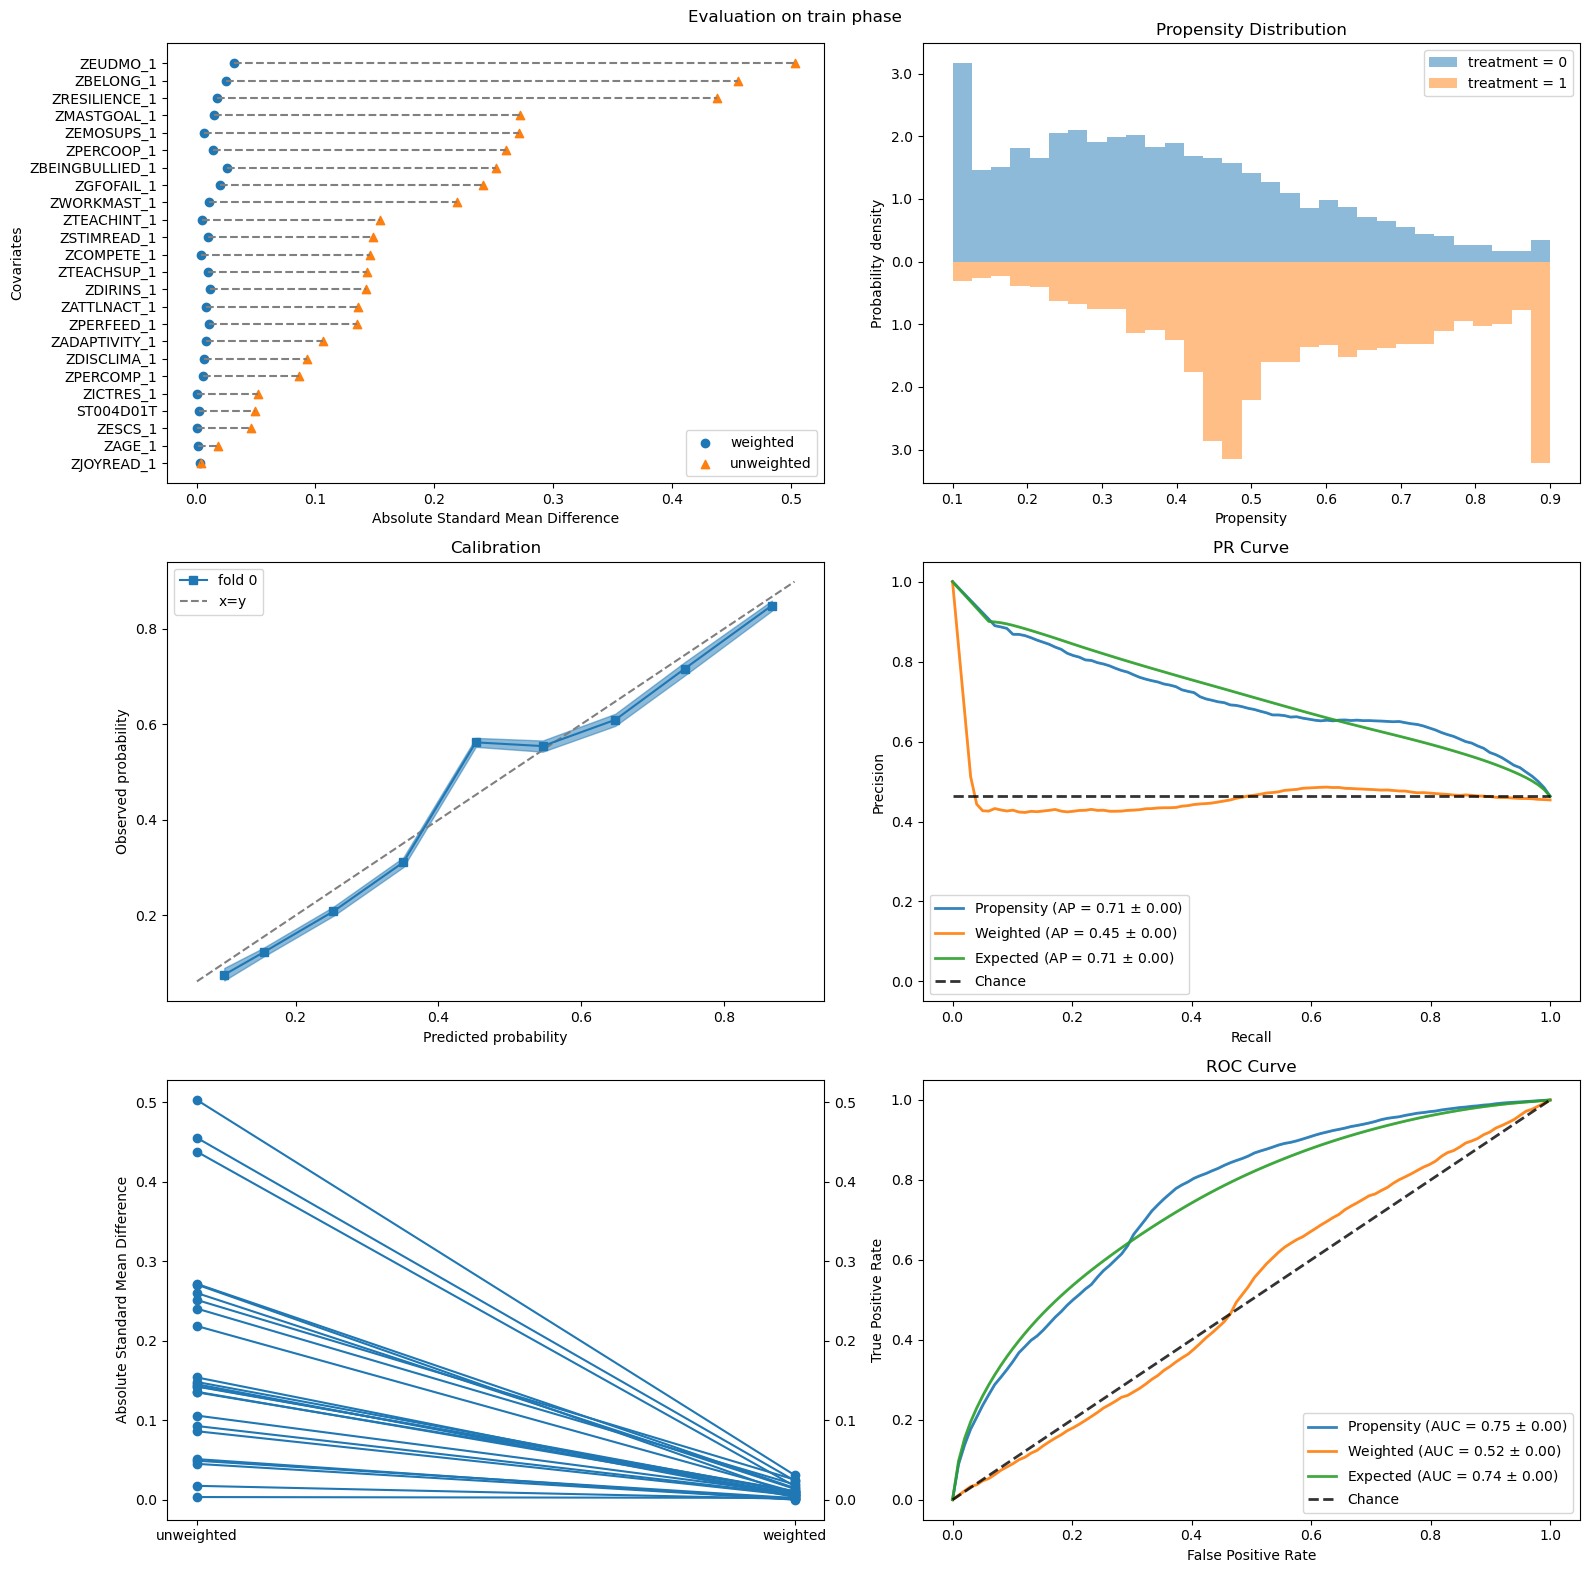

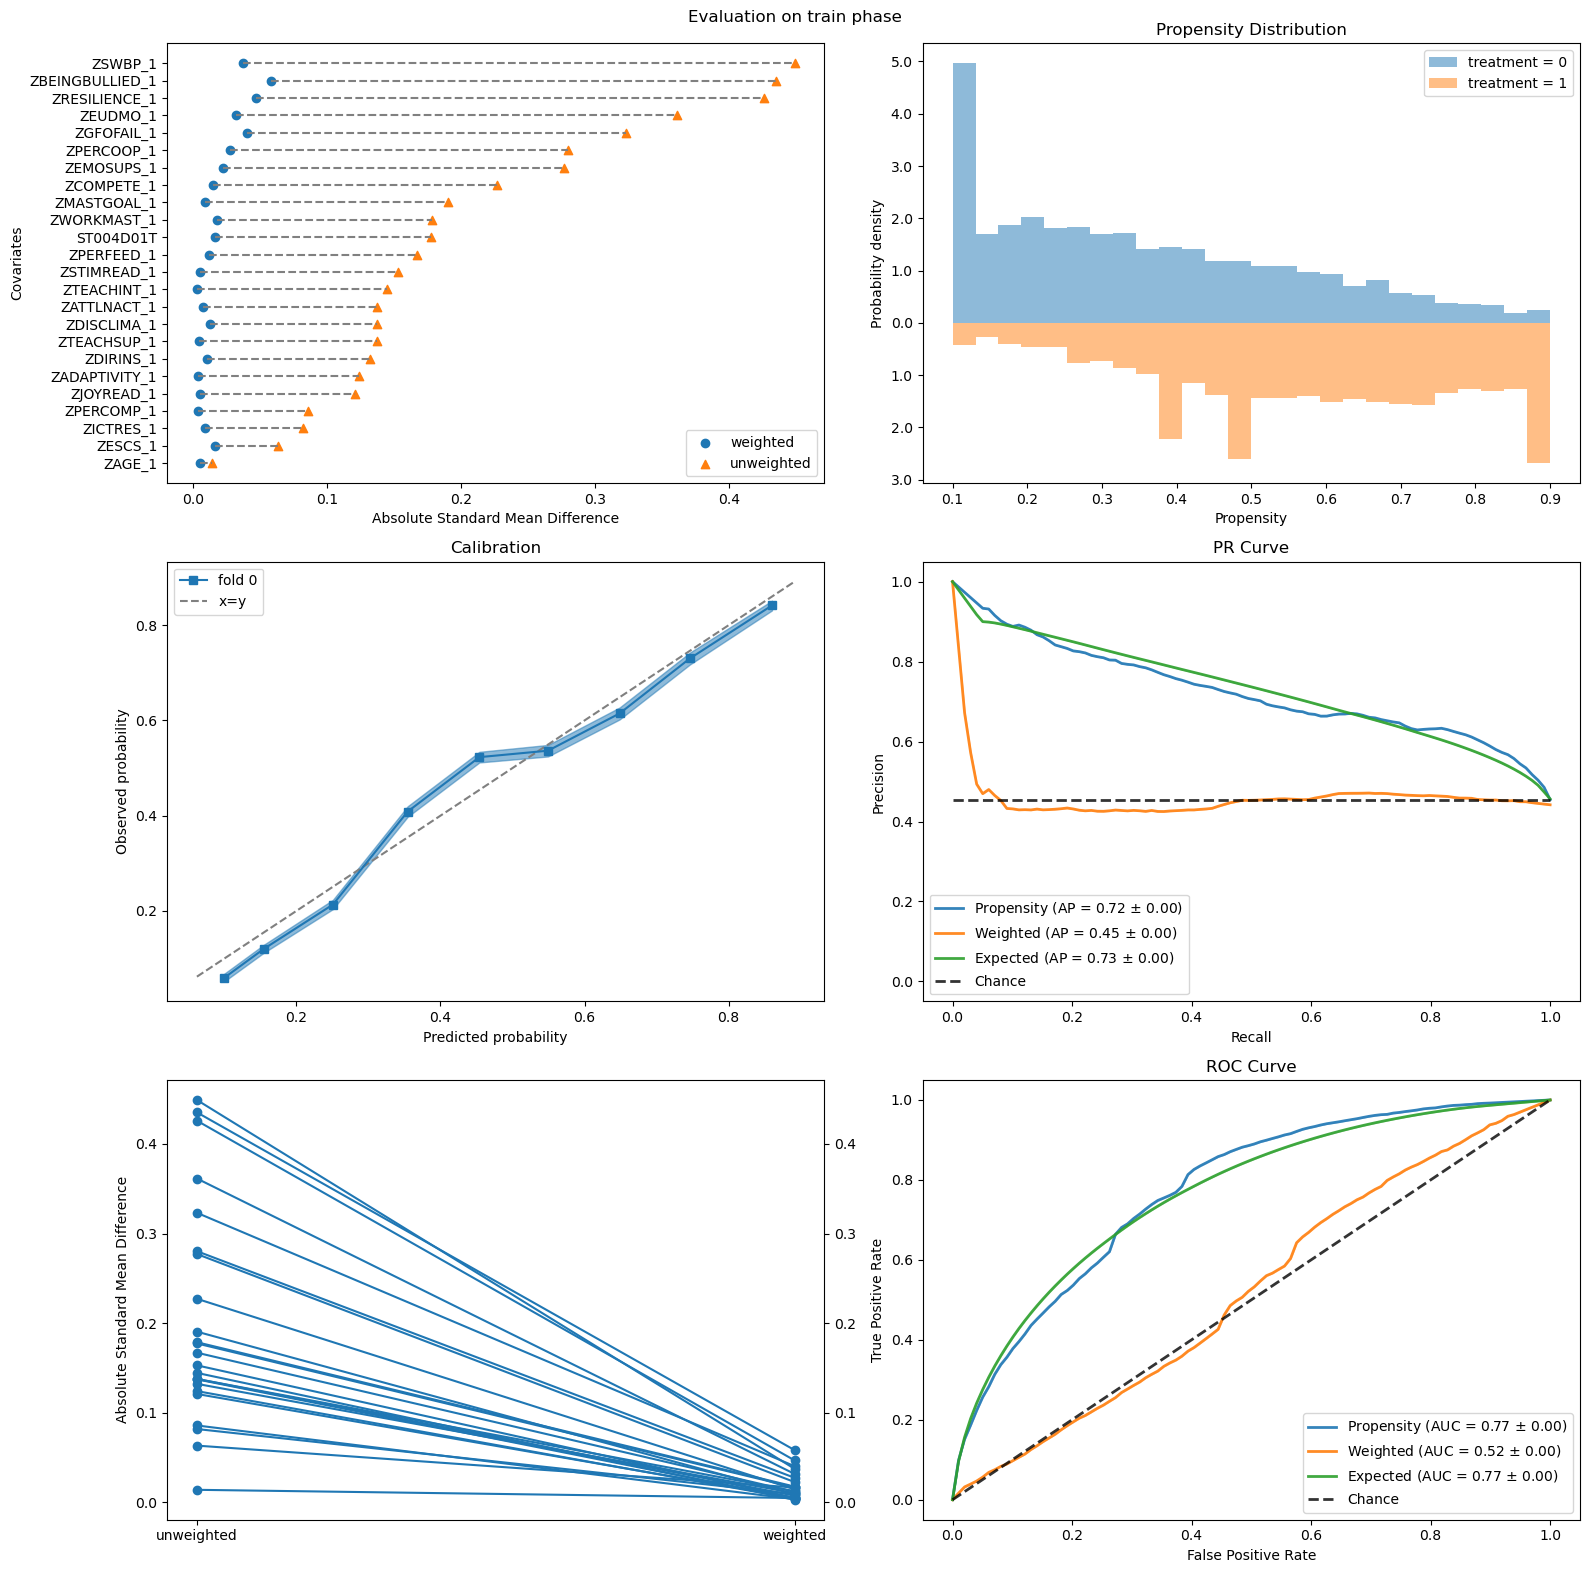

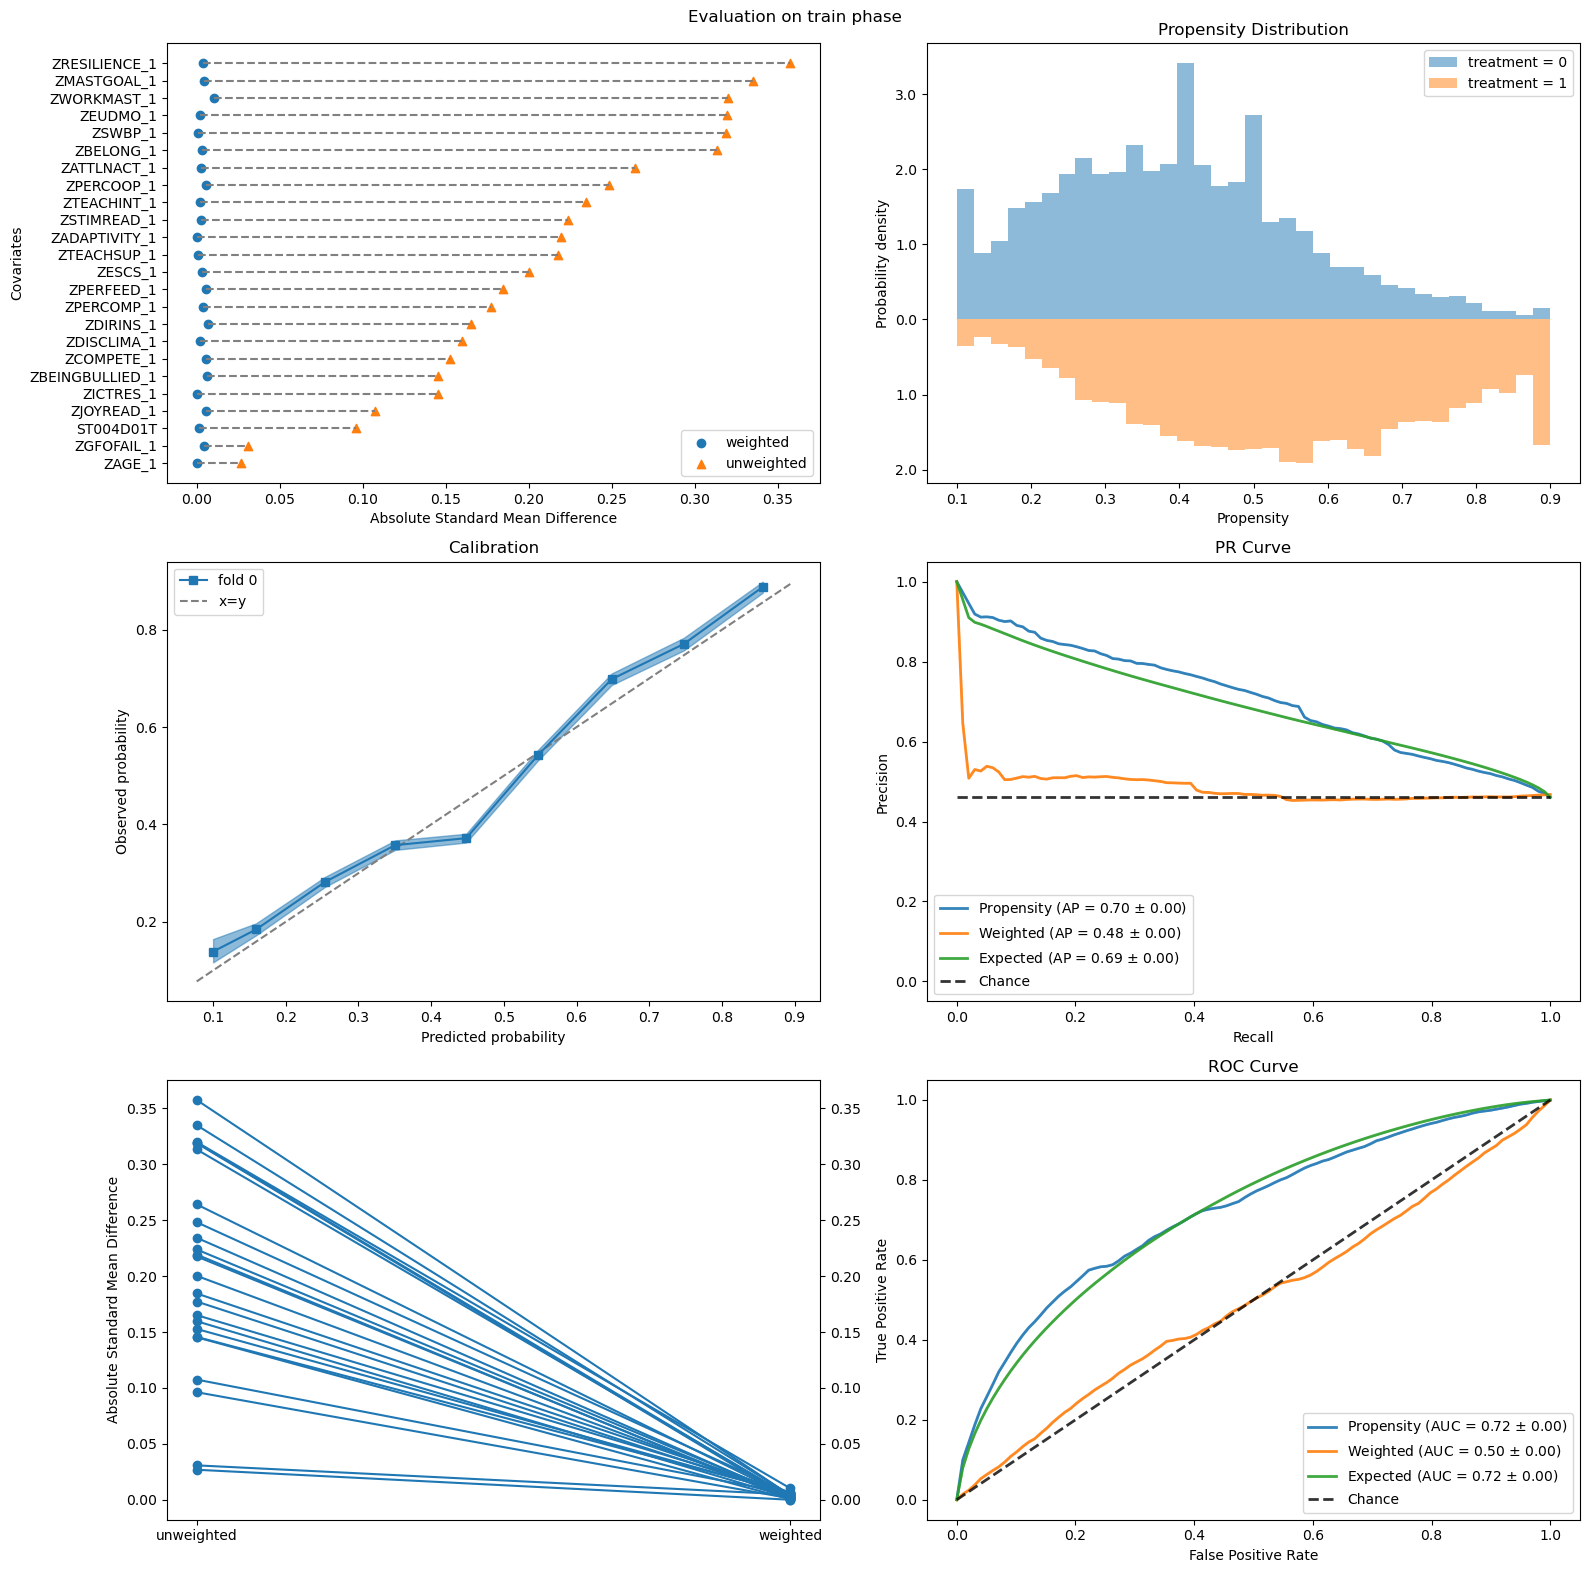

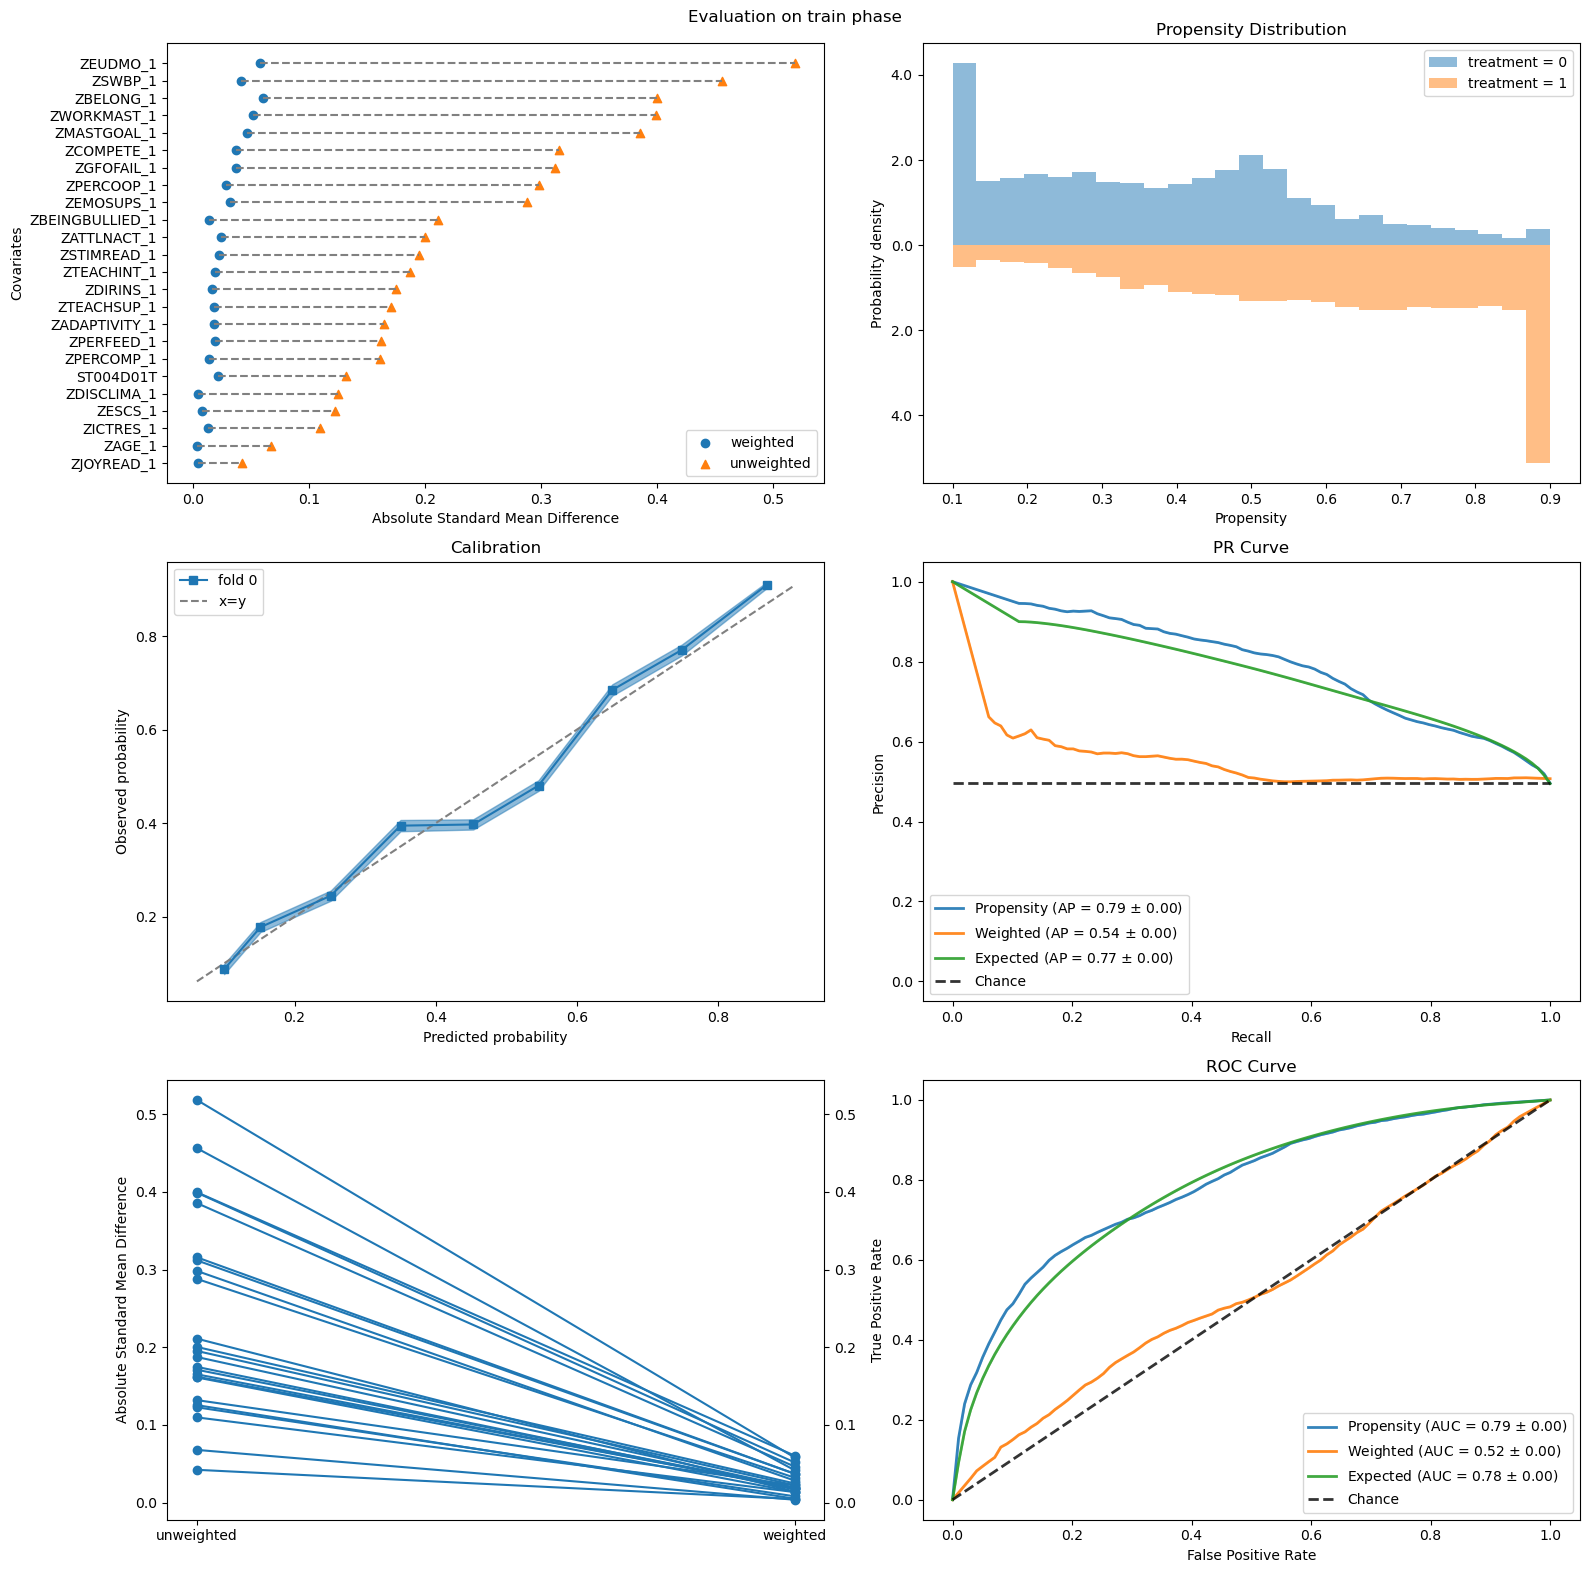

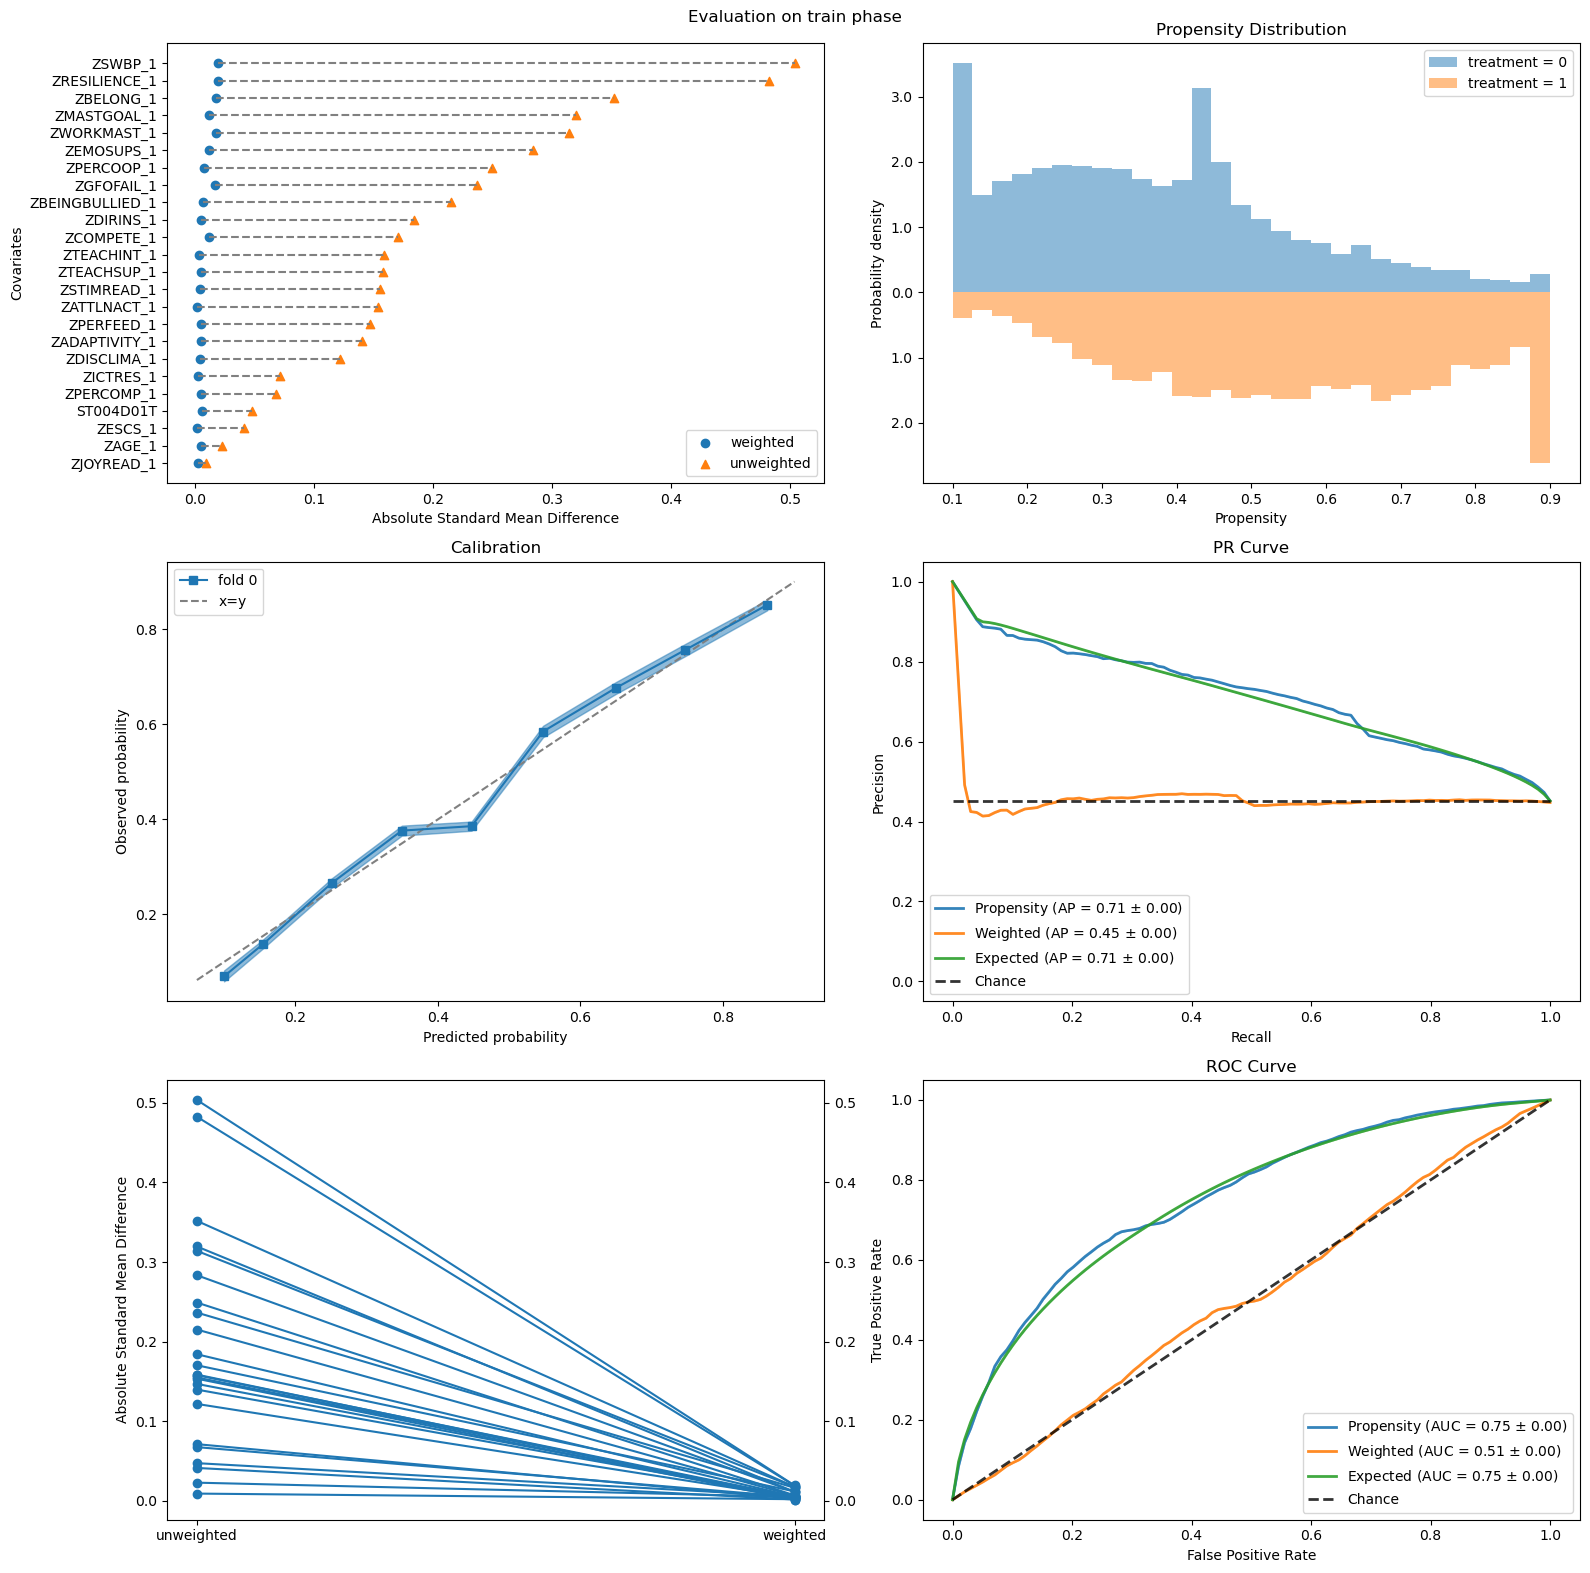

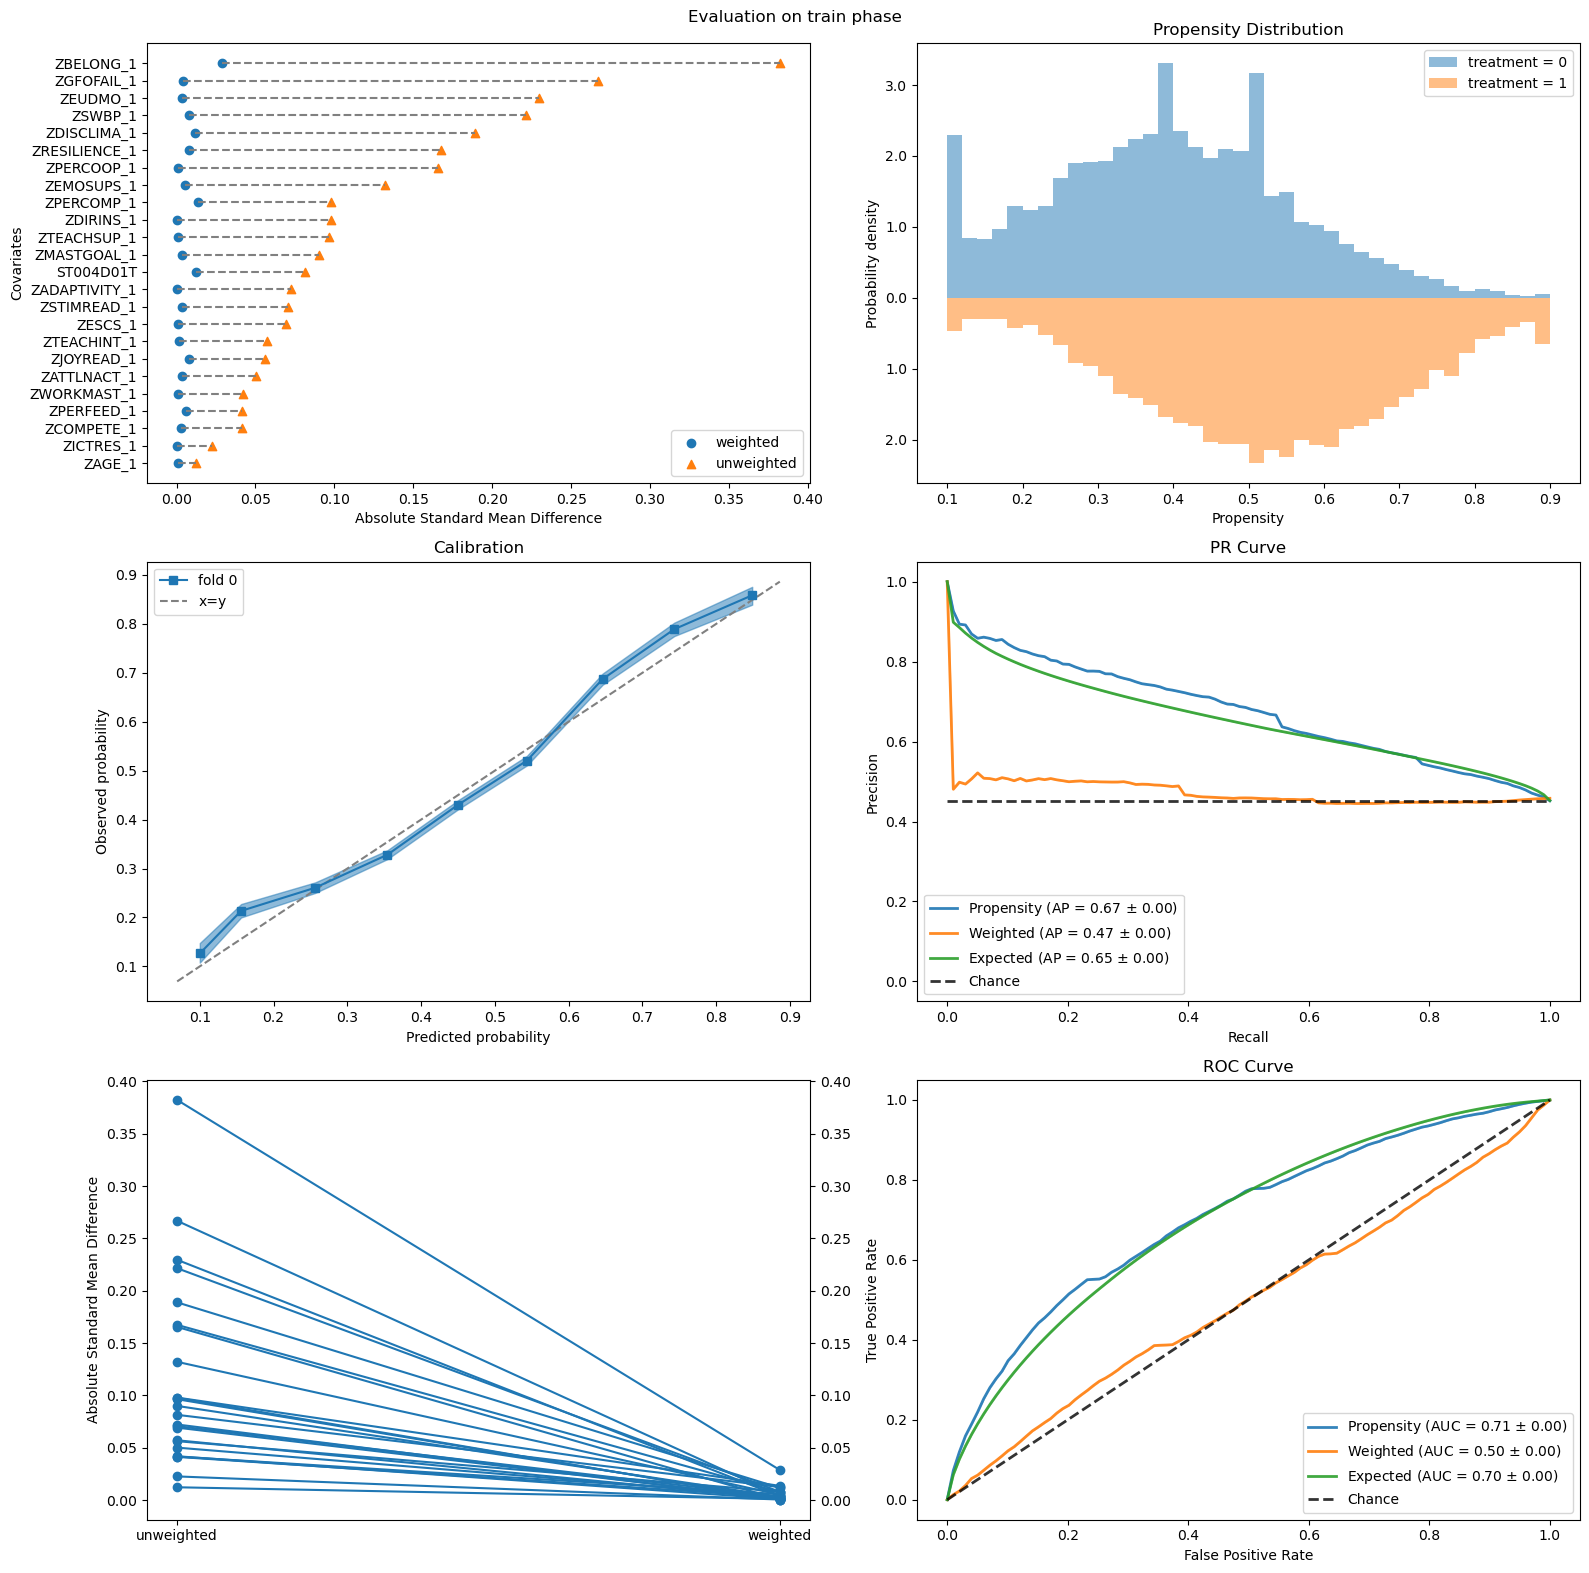

In [9]:
# Select key treatment variables for causal analysis
key_treatments_1 = [
    'ZSWBP_1',       # Positive emotions
    'ZBELONG_1',     # Sense of belonging
    'ZEMOSUPS_1',    # Parental emotional support
    'ZRESILIENCE_1', # Psychological resilience
    'ZEUDMO_1',      # Sense of meaning in life
    'ZBEINGBULLIED_1'# Bullying experiences
]

# Perform causal analysis
causal_results = analyze_multiple_treatments(processed_df_1, key_treatments_1)

# Summarize results
summary = summarize_causal_effects(causal_results)
print("\nCausal Effect Estimates:")
print(summary)